This notebook takes the AOI from the previous notebook and prepares SLC id pairing (aka "enumeration") for submission to the Hyp3-ISCE2 API.

There are two general steps:

1. Create a stack of SLCs from the associated frames covering an AOI.
2. Pair the SLCs (enumeration) for preparation to submit to the Hyp3 API

For each steps, we serialize the data. Note, the first step can be used for multiple enumeration strategies.

Want to note the following definition of terms. We use AOI to describe the initial area of interest e.g. "US CONUS" or "East Coast". We will also use the term "track-AOI" which here allows us to do some accounting that will be helpful for submitting jobs to the API. We are grouping IFGs based on the Sentinel-1 track it falls into. More precise details are in described below.

In [50]:
from s1_frame_enumerator import (get_s1_stack, 
                                 filter_s1_stack_by_geometric_coverage_per_pass, 
                                 get_global_s1_frames, 
                                 get_overlapping_s1_frames, 
                                 enumerate_dates, 
                                 frames2gdf, 
                                 enumerate_gunw_time_series,
                                 gdf2frames)
from shapely.geometry import Point
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import warnings
import json
import pandas as pd
import datetime
from tqdm import tqdm
from pathlib import Path
from itertools import starmap
import yaml
from enum_utils import get_enum_dir, get_stack_dir

# Paramaters

For reuse - we store the enumeration parameters in a yaml file. Ideally, the yaml file changes more than this notebook.

In [7]:
YAML_FILE = 'enumeration_parameters.yml'
with open(YAML_FILE) as f:
    enum_params = yaml.safe_load(f)['enumeration_parameters']

# Load Parameters

In [52]:
# Hyp3 Paramaters
TEMPORAL_BASELINES_DAYS = enum_params['min_temporal_baseline_days']
NEIGHBORS = enum_params['neighbors']
IONOSPHERE = True
SET = True
WEATHER_MODEL = 'HRRR'

# AOI Name
AOI_NAME = enum_params['aoi_name']
STACK_DIR = get_stack_dir(AOI_NAME)
ENUM_DIR = get_enum_dir(AOI_NAME, NEIGHBORS)

# Notebook Parameters; "Recompute" stack means hit the ASF API again to retrieve the latest stack
RECOMPUTE_STACKS = False

In [53]:
STACK_DIR, ENUM_DIR, TEMPORAL_BASELINES_DAYS, NEIGHBORS, WEATHER_MODEL, AOI_NAME, 

(PosixPath('out/us_east/stack'),
 PosixPath('out/us_east/enum/neighbors_3'),
 [0, 180, 365],
 3,
 'HRRR',
 'us_east')

In [16]:
stack_dir = Path(STACK_DIR)
stack_dir.mkdir(exist_ok=True, parents=True)

enum_dir = Path(ENUM_DIR)
enum_dir.mkdir(exist_ok=True, parents=True)

# Load AOI

<Axes: >

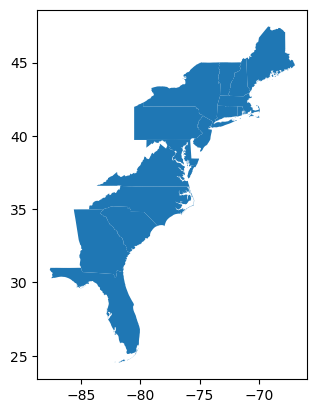

In [17]:
df_coastal_us = gpd.read_file(f'AOIs/{AOI_NAME}.geojson')
# This ensures we only get the mainland part
df_coastal_us.plot()

# Get Frames overlapping AOI

In [18]:
aoi_geo = df_coastal_us.geometry.unary_union
frames = get_overlapping_s1_frames(aoi_geo)
df_frames_all = frames2gdf(frames)
df_frames_all.head()

,frame_id,hemisphere,track_number_min,track_number_max,geometry
0,491,west,4,4,"POLYGON Z ((-77.55802 33.30969 0.00000, -77.71..."
1,492,west,4,4,"POLYGON Z ((-77.82534 34.47332 0.00000, -78.06..."
2,493,west,4,4,"POLYGON Z ((-78.09591 35.63539 0.00000, -78.33..."
3,494,west,4,4,"POLYGON Z ((-78.37797 36.81111 0.00000, -78.41..."
4,495,west,4,4,"POLYGON Z ((-78.65322 37.95742 0.00000, -78.73..."


Let's remove frames that have less than 25% overlap with our AOI. This ensures ISCE2 will have roughly enough area to process.

In [19]:
intersection_geo = df_frames_all.geometry.intersection(aoi_geo)
with warnings.catch_warnings():
    # yes, we are computing areas in lat/lon - that's ok at these latitudes
    warnings.simplefilter("ignore", category=UserWarning)
    percent_overlap = intersection_geo.area / df_frames_all.geometry.area
df_frames = df_frames_all[percent_overlap >= .2].reset_index(drop=True)
df_frames = df_frames.explode()
frames = gdf2frames(df_frames)

/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_29236/3762525945.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df_frames = df_frames.explode()


(23.70927522851776, 48.679921286366046)

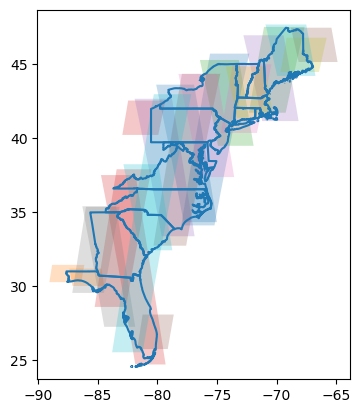

In [20]:
fig, ax = plt.subplots()
df_coastal_us.geometry.boundary.plot(ax=ax)
df_frames_by_track = df_frames.dissolve(by='track_number_min').reset_index(drop=False)
df_frames_by_track.plot(ax=ax, 
                        column='track_number_min',
                        categorical=True,
                        alpha=.25, 
                        #legend=True
                       )
xmin, ymin, xmax, ymax = df_frames_by_track.total_bounds
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_ylim(ymin - 1, ymax + 1)

# Get Stack from Frame

Here a "stack" refers to obtaining all the SLC's that intersect spatially fixed frames which lie on a given track (you can only do InSAR with a fixed SAR geometry! i.e. on a fixed track). See [frame-enumerator](https://github.com/ACCESS-Cloud-Based-InSAR/s1-frame-enumerator) repository for more details about frames and enumeration.

We serialize each stack with respect to a contiguous set of frames that overlap our AOI. More details on accounting below.

If `RECOMPUTE_STACKS` is True, then will overwrite existing stack to retreive the most-up-to-date stack. Our generation of a stack relies on simply hitting the ASF API through its sdk.

Creating a workflow that "updates" an existing serialized stack is beyond the scope of this notebook, and quite frankly not recommended, as such would require book-keeping that would significantly bloat this notebook. Having a stack generated in less than 30 minutes seems reasonable. Also, since the serialization is done, this data can be reused without running this cell.

In [27]:
all_tracks = df_frames.track_number_min.unique().tolist()

An important book-keeping piece is that we are going to group the frames by track *and* by connectedness into what we will also call a "track-AOIs". These "track-AOIs" are simply the groups we submit jobs to Hyp3. Put in a slightly different way, a "track-AOI" is simply a contiguous set of frames that overlap our AOI. Note that a single track can become disconnected based on our AOI (this is often cause by concavity in the original AOI, see the figure above, can you spot a few such tracks?). We will name these track AOIs based on `track{N}` and if there are additional track areas we will call them `track{N}-_{index}` e.g. `track23, track23_1, ...`.

**Warning**: We have the initial "AOI" which refers to a general area of interest for a science use case such as "US CONUS" and now we *also* are grouping frames into "track-AOIs" for accounting jobs submitted to Hyp3.

Below we create dictionary with key `track_AOI_ID` and value a list of frames within that area. A frame is simply a data container

In [22]:
def id_formatter(row: pd.Series):
    """Returns 'track<track_number>' for first instance and then 'track<track_number>_k' for each subsequent k index"""
    if row['level_1']:
        return f"track{row['track_number_min']}_{row['level_1']}"
    else:
        return f"track{row['track_number_min']}"

df_track_aois = df_frames_by_track.explode().reset_index(drop=False)
df_track_aois['track_aoi_id'] = df_track_aois.apply(id_formatter, axis=1)
df_track_aois.head()

/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_29236/2628663778.py:8: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df_track_aois = df_frames_by_track.explode().reset_index(drop=False)


,level_0,level_1,track_number_min,frame_id,hemisphere,track_number_max,geometry,track_aoi_id
0,0,0,4,492,west,4,"POLYGON Z ((-78.06076 35.48755 0.00000, -78.06...",track4
1,1,0,11,1624,west,11,"POLYGON Z ((-77.75658 35.26745 0.00000, -77.75...",track11
2,2,0,19,2796,west,19,"POLYGON Z ((-87.13180 30.16271 0.00000, -87.32...",track19
3,3,0,26,3951,west,26,"POLYGON Z ((-89.02007 30.30462 0.00000, -88.98...",track26
4,4,0,33,4964,west,33,"POLYGON Z ((-74.99244 39.81098 0.00000, -75.20...",track33


In [23]:
track2frames = {row['track_aoi_id']: [f for f in frames 
                                      if row['track_number_min'] in f.track_numbers 
                                      if row['geometry'].intersects(f.frame_geometry)
                       ] 
                for _, row in df_track_aois.iterrows()}
track2frames['track4']

[S1Frame(frame_id=492, hemisphere='west', track_numbers=[4], frame_geometry=<POLYGON Z ((-77.825 34.473 0, -78.064 35.483 0, -78.06 35.484 0, -78.061 35...>, footprint_geometry=<POLYGON ((-77.744 34.126, -78.064 35.483, -78.06 35.484, -78.099 35.65, -77...>),
 S1Frame(frame_id=493, hemisphere='west', track_numbers=[4], frame_geometry=<POLYGON Z ((-78.096 35.635 0, -78.339 36.651 0, -75.472 36.651 0, -75.298 3...>, footprint_geometry=<POLYGON ((-75.238 35.485, -75.2 35.298, -76.07 35.183, -76.093 35.292, -76....>),
 S1Frame(frame_id=494, hemisphere='west', track_numbers=[4], frame_geometry=<POLYGON Z ((-78.378 36.811 0, -78.414 36.977 0, -78.618 37.813 0, -75.706 3...>, footprint_geometry=<POLYGON ((-77.308 36.32, -77.368 36.585, -78.291 36.45, -78.378 36.811, -78...>),
 S1Frame(frame_id=495, hemisphere='west', track_numbers=[4], frame_geometry=<POLYGON Z ((-78.653 37.957 0, -78.739 38.304 0, -78.734 38.305 0, -78.901 3...>, footprint_geometry=<POLYGON ((-77.57 37.482, -77.632 37.746, -

For each `track_aoi_id`, we save the stack as `track{N}-{AOI_NAME}`, hopefully the multiple use of "AOIs" is clear.

In [24]:
track_log = tqdm(total=0, position=0, bar_format='{desc}')

def get_s1_stack_and_serialize(track_aoi_id, frames, recompute_stack=RECOMPUTE_STACKS):
    if not frames:
        warnings.warn('No frames submitted')
        return
    track_stack_path = stack_dir / f'{track_aoi_id}-{AOI_NAME}.geojson'
    track_log.set_description_str(f'Current track: {track_stack_path}')
    if track_stack_path.exists() and (not recompute_stack):
        return track_stack_path
    df_stack = get_s1_stack(frames, minimum_coverage_ratio_per_frame=.2, minimum_coverage_ratio_per_pass=.8)
    if df_stack.empty:
        warnings.warn(f'Empty stack - still writing for records - check {track_aoi_id} on asf_search')
    df_stack.to_file(track_stack_path, driver='GeoJSON')
    return track_stack_path

In [25]:
input_frame_data = list(track2frames.items())
stack_paths = list(starmap(get_s1_stack_and_serialize, tqdm(input_frame_data)))


Current track: out/us_east/stack/track4-us_east.geojson                                              | 0/23 [00:00<?, ?it/s]









/Users/cmarshak/bekaert-team/s1-frame-enumerator/s1_frame_enumerator/s1_stack.py:80: UserWarning: Frame 496 did not have enough coverage on 2016-09-24 (ratio of coverage was 0.18)
  warn(f'Frame {frame.frame_id} did not have enough coverage '

Current track: out/us_east/stack/track11-us_east.geojson                                     | 1/23 [01:34<34:41, 94.61s/it]











/Users/cmarshak/bekaert-team/s1-frame-enumerator/s1_frame_enumerator/s1_stack.py:137: UserWarning: Ensuring per pass coverage of 0.8 left no available images in the stack
  warn(f'Ensuring per pass coverage of {ratio} left no available images in the stack',
/Users/cmarshak/bekaert-team/s1-frame-enumerator/s1_frame_enumerator/s1_stack.py:146: UserWarning: Ensuring per frame coverage of 0.2 left no available images in the stack
  warn(f'Ensuring per frame coverage of {ratio} left no











/Users/cmarshak/bekaert-team/s1-frame-enumerator/s1_frame_enumerator/s1_stack.py:80: UserWarning: Frame 7349 did not have enough coverage on 2022-01-11 (ratio of coverage was 0.05)
  warn(f'Frame {frame.frame_id} did not have enough coverage '

Current track: out/us_east/stack/track55-us_east.geojson                                     | 7/23 [06:23<19:43, 74.00s/it]










Current track: out/us_east/stack/track55_1-us_east.geojson                                   | 8/23 [06:46<14:30, 58.04s/it]



/Users/cmarshak/bekaert-team/s1-frame-enumerator/s1_frame_enumerator/s1_stack.py:137: UserWarning: Ensuring per pass coverage of 0.8 left no available images in the stack
  warn(f'Ensuring per pass coverage of {ratio} left no available images in the stack',
/Users/cmarshak/bekaert-team/s1-frame-enumerator/s1_frame_enumerator/s1_stack.py:146: UserWarning: Ensuring per frame coverage of 0.2 left no available images in the stack
  warn(f'Ensuring per frame coverage of {ratio} left






/Users/cmarshak/bekaert-team/s1-frame-enumerator/s1_frame_enumerator/s1_stack.py:137: UserWarning: Ensuring per pass coverage of 0.8 left no available images in the stack
  warn(f'Ensuring per pass coverage of {ratio} left no available images in the stack',
/Users/cmarshak/bekaert-team/s1-frame-enumerator/s1_frame_enumerator/s1_stack.py:146: UserWarning: Ensuring per frame coverage of 0.2 left no available images in the stack
  warn(f'Ensuring per frame coverage of {ratio} left no available images in the stack',
/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_29236/1383881219.py:13: UserWarning: Empty stack - still writing for records - check track84_1 on asf_search
  warnings.warn(f'Empty stack - still writing for records - check {track_aoi_id} on asf_search')
/Users/cmarshak/mambaforge/envs/s1-frame-enumerator/lib/python3.11/site-packages/geopandas/io/file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may

Current track: out/us_east/stack/track150-us_east.geojson███████████████████████▋           | 20/23 [18:10<03:04, 61.55s/it]







Current track: out/us_east/stack/track157-us_east.geojson███████████████████████████▍       | 21/23 [20:59<03:07, 93.90s/it]
















/Users/cmarshak/bekaert-team/s1-frame-enumerator/s1_frame_enumerator/s1_stack.py:137: UserWarning: Ensuring per pass coverage of 0.8 left no available images in the stack
  warn(f'Ensuring per pass coverage of {ratio} left no available images in the stack',
/Users/cmarshak/bekaert-team/s1-frame-enumerator/s1_frame_enumerator/s1_stack.py:146: UserWarning: Ensuring per frame coverage of 0.2 left no available images in the stack
  warn(f'Ensuring per frame coverage of {ratio} left no available images in the stack',
/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_29236/1383881219.py:13: UserWarning: Empty stack - still writing for records - check track157 on asf_search
  warnings.warn(f'Empty stack - still writ

# Generate IFG Pairs

In [42]:
IFG_COLUMNS = ['reference', 'secondary', 'reference_date', 'secondary_date', 'frame_id', 'geometry']
def encode_dataframe_for_serialization(df_ifg: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    df_ifg['reference_date'] = df_ifg['reference_date'].dt.date.astype(str)
    df_ifg['secondary_date'] = df_ifg['secondary_date'].dt.date.astype(str)
    
    df_ifg['reference'] = df_ifg['reference'].map(lambda l: ' '.join(l))
    df_ifg['secondary'] = df_ifg['secondary'].map(lambda l: ' '.join(l))
    
    df_ifg.crs = CRS.from_epsg(4326)
    return df_ifg  


def enumerate_one_stack(stack_path: Path, 
                        temporal_baselines_days: list = None, 
                        neighbors=NEIGHBORS):
    temporal_baselines_days = temporal_baselines_days or TEMPORAL_BASELINES_DAYS
    df_stack = gpd.read_file(stack_path)
    
    stack_path_stem = stack_path.stem
    track_aoi_key, aoi_name = stack_path_stem.split('-')
    
    frames = track2frames[track_aoi_key]
    enum_data_path_track_aoi = enum_dir / f'{track_aoi_key}-{aoi_name}.geojson'
    
    # We prepare an empty output dataframe in case any steps yeild empty frames
    df_ifg = gpd.GeoDataFrame(columns=IFG_COLUMNS)
    df_ifg.crs = CRS.from_epsg(4326)
    
    # ## Only check if HRRR and nonempty stack
    # if WEATHER_MODEL == 'HRRR' and (not df_stack.empty):
    #    cond = df_stack.repeat_pass_timestamp < (pd.Timestamp.today(tz='UTC') - pd.Timedelta(days=93))
    #    df_stack = df_stack[cond].reset_index(drop=True)

    all_data = []
    # Only enumerate if stack non-empty
    if not df_stack.empty:
        for tb in temporal_baselines_days:
            data = enumerate_gunw_time_series(df_stack, 
                                              tb, 
                                              n_secondary_scenes_per_ref=NEIGHBORS,
                                              frames=frames 
                                              )
            all_data += data

    # There are situations when the stack is non-empty and we have no pairs (literally one pass - see track 55)
    if all_data:
        df_ifg = gpd.GeoDataFrame(all_data)
        df_ifg = df_ifg.drop_duplicates(subset=['reference_date', 
                                                'secondary_date', 
                                                'frame_id']).reset_index(drop=True)
        df_ifg = encode_dataframe_for_serialization(df_ifg)
        
        # Write some important parameters
        df_ifg['track_aoi_key'] = track_aoi_key
        df_ifg['aoi_name'] = aoi_name
        df_ifg['neighbors'] = NEIGHBORS
    
    df_ifg.to_file(enum_data_path_track_aoi, driver='GeoJSON')
    return enum_data_path_track_aoi

In [43]:
ifg_data_paths = list(map(enumerate_one_stack, tqdm(stack_paths[:])))


  0%|                                                                                                | 0/23 [00:00<?, ?it/s]

Date Pairs:   0%|                                                                                   | 0/579 [00:00<?, ?it/s]

Date Pairs:   0%|▎                                                                          | 2/579 [00:00<00:52, 11.07it/s]

Date Pairs:   1%|▌                                                                          | 4/579 [00:00<00:50, 11.35it/s]

Date Pairs:   1%|▊                                                                          | 6/579 [00:00<00:49, 11.47it/s]

Date Pairs:   1%|█                                                                          | 8/579 [00:00<00:49, 11.51it/s]

Date Pairs:   2%|█▎                                                                        | 10/579 [00:00<00:49, 11.49it/s]

Date Pairs:   2%|█▌                                                                        | 12/579 [00:01<00:49, 11.

Date Pairs:  21%|███████████████▍                                                         | 122/579 [00:10<00:40, 11.40it/s]

Date Pairs:  21%|███████████████▋                                                         | 124/579 [00:10<00:39, 11.39it/s]

Date Pairs:  22%|███████████████▉                                                         | 126/579 [00:11<00:39, 11.39it/s]

Date Pairs:  22%|████████████████▏                                                        | 128/579 [00:11<00:39, 11.40it/s]

Date Pairs:  22%|████████████████▍                                                        | 130/579 [00:11<00:39, 11.34it/s]

Date Pairs:  23%|████████████████▋                                                        | 132/579 [00:11<00:39, 11.26it/s]

Date Pairs:  23%|████████████████▉                                                        | 134/579 [00:11<00:39, 11.30it/s]

Date Pairs:  23%|█████████████████▏                                                       | 136/579 [00:12<00:39, 11.2

Date Pairs:  42%|███████████████████████████████                                          | 246/579 [00:21<00:29, 11.14it/s]

Date Pairs:  43%|███████████████████████████████▎                                         | 248/579 [00:21<00:29, 11.19it/s]

Date Pairs:  43%|███████████████████████████████▌                                         | 250/579 [00:22<00:29, 11.18it/s]

Date Pairs:  44%|███████████████████████████████▊                                         | 252/579 [00:22<00:29, 11.20it/s]

Date Pairs:  44%|████████████████████████████████                                         | 254/579 [00:22<00:29, 11.19it/s]

Date Pairs:  44%|████████████████████████████████▎                                        | 256/579 [00:22<00:28, 11.22it/s]

Date Pairs:  45%|████████████████████████████████▌                                        | 258/579 [00:22<00:28, 11.25it/s]

Date Pairs:  45%|████████████████████████████████▊                                        | 260/579 [00:23<00:28, 11.2

Date Pairs:  64%|██████████████████████████████████████████████▋                          | 370/579 [00:32<00:18, 11.06it/s]

Date Pairs:  64%|██████████████████████████████████████████████▉                          | 372/579 [00:33<00:18, 11.03it/s]

Date Pairs:  65%|███████████████████████████████████████████████▏                         | 374/579 [00:33<00:18, 10.95it/s]

Date Pairs:  65%|███████████████████████████████████████████████▍                         | 376/579 [00:33<00:18, 10.99it/s]

Date Pairs:  65%|███████████████████████████████████████████████▋                         | 378/579 [00:33<00:18, 11.04it/s]

Date Pairs:  66%|███████████████████████████████████████████████▉                         | 380/579 [00:33<00:18, 11.00it/s]

Date Pairs:  66%|████████████████████████████████████████████████▏                        | 382/579 [00:33<00:17, 10.98it/s]

Date Pairs:  66%|████████████████████████████████████████████████▍                        | 384/579 [00:34<00:17, 10.9

Date Pairs:  85%|██████████████████████████████████████████████████████████████▎          | 494/579 [00:44<00:07, 10.77it/s]

Date Pairs:  86%|██████████████████████████████████████████████████████████████▌          | 496/579 [00:44<00:07, 10.84it/s]

Date Pairs:  86%|██████████████████████████████████████████████████████████████▊          | 498/579 [00:44<00:07, 10.90it/s]

Date Pairs:  86%|███████████████████████████████████████████████████████████████          | 500/579 [00:44<00:07, 10.94it/s]

Date Pairs:  87%|███████████████████████████████████████████████████████████████▎         | 502/579 [00:44<00:07, 10.95it/s]

Date Pairs:  87%|███████████████████████████████████████████████████████████████▌         | 504/579 [00:45<00:06, 10.99it/s]

Date Pairs:  87%|███████████████████████████████████████████████████████████████▊         | 506/579 [00:45<00:06, 10.99it/s]

Date Pairs:  88%|████████████████████████████████████████████████████████████████         | 508/579 [00:45<00:06, 11.0

Date Pairs:   8%|█████▉                                                                    | 38/472 [00:03<00:40, 10.79it/s]

Date Pairs:   8%|██████▎                                                                   | 40/472 [00:03<00:40, 10.79it/s]

Date Pairs:   9%|██████▌                                                                   | 42/472 [00:03<00:39, 10.85it/s]

Date Pairs:   9%|██████▉                                                                   | 44/472 [00:04<00:39, 10.83it/s]

Date Pairs:  10%|███████▏                                                                  | 46/472 [00:04<00:39, 10.87it/s]

Date Pairs:  10%|███████▌                                                                  | 48/472 [00:04<00:38, 10.92it/s]

Date Pairs:  11%|███████▊                                                                  | 50/472 [00:04<00:38, 10.91it/s]

Date Pairs:  11%|████████▏                                                                 | 52/472 [00:04<00:38, 10.9

Date Pairs:  31%|██████████████████████▍                                                  | 145/472 [00:13<00:33,  9.77it/s]

Date Pairs:  31%|██████████████████████▋                                                  | 147/472 [00:14<00:32, 10.01it/s]

Date Pairs:  32%|███████████████████████                                                  | 149/472 [00:14<00:31, 10.18it/s]

Date Pairs:  32%|███████████████████████▎                                                 | 151/472 [00:14<00:31, 10.23it/s]

Date Pairs:  32%|███████████████████████▋                                                 | 153/472 [00:14<00:31, 10.11it/s]

Date Pairs:  33%|███████████████████████▉                                                 | 155/472 [00:14<00:31, 10.17it/s]

Date Pairs:  33%|████████████████████████▎                                                | 157/472 [00:15<00:31,  9.91it/s]

Date Pairs:  33%|████████████████████████▍                                                | 158/472 [00:15<00:32,  9.7

Date Pairs:  54%|███████████████████████████████████████▎                                 | 254/472 [00:24<00:20, 10.57it/s]

Date Pairs:  54%|███████████████████████████████████████▌                                 | 256/472 [00:24<00:20, 10.62it/s]

Date Pairs:  55%|███████████████████████████████████████▉                                 | 258/472 [00:24<00:20, 10.56it/s]

Date Pairs:  55%|████████████████████████████████████████▏                                | 260/472 [00:24<00:19, 10.61it/s]

Date Pairs:  56%|████████████████████████████████████████▌                                | 262/472 [00:25<00:19, 10.70it/s]

Date Pairs:  56%|████████████████████████████████████████▊                                | 264/472 [00:25<00:19, 10.79it/s]

Date Pairs:  56%|█████████████████████████████████████████▏                               | 266/472 [00:25<00:18, 10.85it/s]

Date Pairs:  57%|█████████████████████████████████████████▍                               | 268/472 [00:25<00:18, 10.8

Date Pairs:  80%|██████████████████████████████████████████████████████████▍              | 378/472 [00:35<00:09,  9.90it/s]

Date Pairs:  81%|██████████████████████████████████████████████████████████▊              | 380/472 [00:36<00:09, 10.03it/s]

Date Pairs:  81%|███████████████████████████████████████████████████████████              | 382/472 [00:36<00:08, 10.14it/s]

Date Pairs:  81%|███████████████████████████████████████████████████████████▍             | 384/472 [00:36<00:08, 10.29it/s]

Date Pairs:  82%|███████████████████████████████████████████████████████████▋             | 386/472 [00:36<00:08, 10.37it/s]

Date Pairs:  82%|████████████████████████████████████████████████████████████             | 388/472 [00:36<00:07, 10.52it/s]

Date Pairs:  83%|████████████████████████████████████████████████████████████▎            | 390/472 [00:36<00:07, 10.62it/s]

Date Pairs:  83%|████████████████████████████████████████████████████████████▋            | 392/472 [00:37<00:07, 10.6

Date Pairs:  17%|████████████▌                                                             | 24/142 [00:02<00:10, 10.78it/s]

Date Pairs:  18%|█████████████▌                                                            | 26/142 [00:02<00:10, 10.82it/s]

Date Pairs:  20%|██████████████▌                                                           | 28/142 [00:02<00:10, 10.88it/s]

Date Pairs:  21%|███████████████▋                                                          | 30/142 [00:02<00:10, 10.87it/s]

Date Pairs:  23%|████████████████▋                                                         | 32/142 [00:02<00:10, 10.83it/s]

Date Pairs:  24%|█████████████████▋                                                        | 34/142 [00:03<00:09, 10.85it/s]

Date Pairs:  25%|██████████████████▊                                                       | 36/142 [00:03<00:09, 10.90it/s]

Date Pairs:  27%|███████████████████▊                                                      | 38/142 [00:03<00:09, 10.8



Date Pairs:   0%|                                                                                   | 0/576 [00:00<?, ?it/s]

Date Pairs:   2%|█▏                                                                         | 9/576 [00:00<00:06, 87.26it/s]

Date Pairs:   3%|██▎                                                                       | 18/576 [00:00<00:12, 45.79it/s]

Date Pairs:   5%|███▍                                                                      | 27/576 [00:00<00:09, 58.18it/s]

Date Pairs:   6%|████▋                                                                     | 36/576 [00:00<00:08, 67.07it/s]

Date Pairs:   8%|█████▊                                                                    | 45/576 [00:00<00:07, 73.43it/s]

Date Pairs:   9%|██████▉                                                                   | 54/576 [00:00<00:06, 77.39it/s]

Date Pairs:  11%|████████                                                                  | 63/576 [00:00<00:06, 78

Date Pairs:  97%|██████████████████████████████████████████████████████████████████████▋  | 558/576 [00:06<00:00, 87.40it/s]

Date Pairs:  98%|███████████████████████████████████████████████████████████████████████▊ | 567/576 [00:06<00:00, 87.65it/s]

Date Pairs: 100%|█████████████████████████████████████████████████████████████████████████| 576/576 [00:06<00:00, 85.45it/s]


Date Pairs:   0%|                                                                                   | 0/385 [00:00<?, ?it/s]

Date Pairs:   2%|█▊                                                                         | 9/385 [00:00<00:04, 88.65it/s]

Date Pairs:   5%|███▍                                                                      | 18/385 [00:00<00:04, 88.44it/s]

Date Pairs:   7%|█████▏                                                                    | 27/385 [00:00<00:04, 88.46it/s]

Date Pairs:   9%|██████▉                                                                   | 36/385 [00:00<00:03, 87.

Date Pairs:   0%|                                                                                   | 0/570 [00:00<?, ?it/s]

Date Pairs:   0%|▎                                                                          | 2/570 [00:00<00:33, 16.92it/s]

Date Pairs:   1%|▌                                                                          | 4/570 [00:00<00:34, 16.60it/s]

Date Pairs:   1%|▊                                                                          | 6/570 [00:00<00:34, 16.42it/s]

Date Pairs:   1%|█                                                                          | 8/570 [00:00<00:33, 16.60it/s]

Date Pairs:   2%|█▎                                                                        | 10/570 [00:00<00:33, 16.75it/s]

Date Pairs:   2%|█▌                                                                        | 12/570 [00:00<00:33, 16.88it/s]

Date Pairs:   2%|█▊                                                                        | 14/570 [00:00<00:32, 17.0

Date Pairs:  22%|███████████████▉                                                         | 124/570 [00:07<00:25, 17.18it/s]

Date Pairs:  22%|████████████████▏                                                        | 126/570 [00:07<00:25, 17.21it/s]

Date Pairs:  22%|████████████████▍                                                        | 128/570 [00:07<00:25, 17.18it/s]

Date Pairs:  23%|████████████████▋                                                        | 130/570 [00:07<00:25, 17.20it/s]

Date Pairs:  23%|████████████████▉                                                        | 132/570 [00:07<00:25, 17.16it/s]

Date Pairs:  24%|█████████████████▏                                                       | 134/570 [00:07<00:25, 17.15it/s]

Date Pairs:  24%|█████████████████▍                                                       | 136/570 [00:07<00:25, 17.15it/s]

Date Pairs:  24%|█████████████████▋                                                       | 138/570 [00:08<00:25, 17.1

Date Pairs:  44%|███████████████████████████████▊                                         | 248/570 [00:14<00:18, 17.11it/s]

Date Pairs:  44%|████████████████████████████████                                         | 250/570 [00:14<00:18, 17.13it/s]

Date Pairs:  44%|████████████████████████████████▎                                        | 252/570 [00:14<00:18, 17.13it/s]

Date Pairs:  45%|████████████████████████████████▌                                        | 254/570 [00:14<00:18, 17.05it/s]

Date Pairs:  45%|████████████████████████████████▊                                        | 256/570 [00:15<00:18, 16.94it/s]

Date Pairs:  45%|█████████████████████████████████                                        | 258/570 [00:15<00:18, 16.85it/s]

Date Pairs:  46%|█████████████████████████████████▎                                       | 260/570 [00:15<00:18, 16.83it/s]

Date Pairs:  46%|█████████████████████████████████▌                                       | 262/570 [00:15<00:18, 16.8

Date Pairs:  65%|███████████████████████████████████████████████▋                         | 372/570 [00:21<00:11, 17.08it/s]

Date Pairs:  66%|███████████████████████████████████████████████▉                         | 374/570 [00:21<00:11, 17.11it/s]

Date Pairs:  66%|████████████████████████████████████████████████▏                        | 376/570 [00:22<00:11, 17.14it/s]

Date Pairs:  66%|████████████████████████████████████████████████▍                        | 378/570 [00:22<00:11, 17.16it/s]

Date Pairs:  67%|████████████████████████████████████████████████▋                        | 380/570 [00:22<00:11, 17.17it/s]

Date Pairs:  67%|████████████████████████████████████████████████▉                        | 382/570 [00:22<00:10, 17.12it/s]

Date Pairs:  67%|█████████████████████████████████████████████████▏                       | 384/570 [00:22<00:11, 16.74it/s]

Date Pairs:  68%|█████████████████████████████████████████████████▍                       | 386/570 [00:22<00:11, 16.2

Date Pairs:  87%|███████████████████████████████████████████████████████████████▌         | 496/570 [00:29<00:04, 16.61it/s]

Date Pairs:  87%|███████████████████████████████████████████████████████████████▊         | 498/570 [00:29<00:04, 15.91it/s]

Date Pairs:  88%|████████████████████████████████████████████████████████████████         | 500/570 [00:29<00:04, 15.83it/s]

Date Pairs:  88%|████████████████████████████████████████████████████████████████▎        | 502/570 [00:29<00:04, 16.06it/s]

Date Pairs:  88%|████████████████████████████████████████████████████████████████▌        | 504/570 [00:30<00:04, 16.30it/s]

Date Pairs:  89%|████████████████████████████████████████████████████████████████▊        | 506/570 [00:30<00:03, 16.54it/s]

Date Pairs:  89%|█████████████████████████████████████████████████████████████████        | 508/570 [00:30<00:03, 16.65it/s]

Date Pairs:  89%|█████████████████████████████████████████████████████████████████▎       | 510/570 [00:30<00:03, 16.6

Date Pairs:  10%|███████▌                                                                  | 48/470 [00:02<00:25, 16.68it/s]

Date Pairs:  11%|███████▊                                                                  | 50/470 [00:03<00:24, 16.83it/s]

Date Pairs:  11%|████████▏                                                                 | 52/470 [00:03<00:24, 16.95it/s]

Date Pairs:  11%|████████▌                                                                 | 54/470 [00:03<00:24, 16.88it/s]

Date Pairs:  12%|████████▊                                                                 | 56/470 [00:03<00:24, 16.94it/s]

Date Pairs:  12%|█████████▏                                                                | 58/470 [00:03<00:24, 17.00it/s]

Date Pairs:  13%|█████████▍                                                                | 60/470 [00:03<00:24, 17.07it/s]

Date Pairs:  13%|█████████▊                                                                | 62/470 [00:03<00:23, 17.0

Date Pairs:  37%|██████████████████████████▋                                              | 172/470 [00:10<00:17, 16.91it/s]

Date Pairs:  37%|███████████████████████████                                              | 174/470 [00:10<00:17, 17.00it/s]

Date Pairs:  37%|███████████████████████████▎                                             | 176/470 [00:10<00:17, 17.03it/s]

Date Pairs:  38%|███████████████████████████▋                                             | 178/470 [00:10<00:17, 17.08it/s]

Date Pairs:  38%|███████████████████████████▉                                             | 180/470 [00:10<00:16, 17.11it/s]

Date Pairs:  39%|████████████████████████████▎                                            | 182/470 [00:10<00:16, 17.07it/s]

Date Pairs:  39%|████████████████████████████▌                                            | 184/470 [00:10<00:16, 17.10it/s]

Date Pairs:  40%|████████████████████████████▉                                            | 186/470 [00:11<00:16, 17.0

Date Pairs:  63%|█████████████████████████████████████████████▉                           | 296/470 [00:17<00:10, 17.09it/s]

Date Pairs:  63%|██████████████████████████████████████████████▎                          | 298/470 [00:17<00:10, 17.12it/s]

Date Pairs:  64%|██████████████████████████████████████████████▌                          | 300/470 [00:18<00:09, 17.12it/s]

Date Pairs:  64%|██████████████████████████████████████████████▉                          | 302/470 [00:18<00:09, 17.13it/s]

Date Pairs:  65%|███████████████████████████████████████████████▏                         | 304/470 [00:18<00:09, 17.13it/s]

Date Pairs:  65%|███████████████████████████████████████████████▌                         | 306/470 [00:18<00:09, 17.12it/s]

Date Pairs:  66%|███████████████████████████████████████████████▊                         | 308/470 [00:18<00:09, 17.15it/s]

Date Pairs:  66%|████████████████████████████████████████████████▏                        | 310/470 [00:18<00:09, 17.1

Date Pairs:  89%|█████████████████████████████████████████████████████████████████▏       | 420/470 [00:25<00:02, 17.18it/s]

Date Pairs:  90%|█████████████████████████████████████████████████████████████████▌       | 422/470 [00:25<00:02, 17.19it/s]

Date Pairs:  90%|█████████████████████████████████████████████████████████████████▊       | 424/470 [00:25<00:02, 17.16it/s]

Date Pairs:  91%|██████████████████████████████████████████████████████████████████▏      | 426/470 [00:25<00:02, 17.14it/s]

Date Pairs:  91%|██████████████████████████████████████████████████████████████████▍      | 428/470 [00:25<00:02, 17.13it/s]

Date Pairs:  91%|██████████████████████████████████████████████████████████████████▊      | 430/470 [00:25<00:02, 17.13it/s]

Date Pairs:  92%|███████████████████████████████████████████████████████████████████      | 432/470 [00:25<00:02, 17.14it/s]

Date Pairs:  92%|███████████████████████████████████████████████████████████████████▍     | 434/470 [00:25<00:02, 17.1

Date Pairs:  50%|█████████████████████████████████████▎                                    | 72/143 [00:04<00:04, 16.78it/s]

Date Pairs:  52%|██████████████████████████████████████▎                                   | 74/143 [00:04<00:04, 16.84it/s]

Date Pairs:  53%|███████████████████████████████████████▎                                  | 76/143 [00:04<00:03, 16.84it/s]

Date Pairs:  55%|████████████████████████████████████████▎                                 | 78/143 [00:04<00:03, 16.79it/s]

Date Pairs:  56%|█████████████████████████████████████████▍                                | 80/143 [00:04<00:03, 16.83it/s]

Date Pairs:  57%|██████████████████████████████████████████▍                               | 82/143 [00:04<00:03, 16.86it/s]

Date Pairs:  59%|███████████████████████████████████████████▍                              | 84/143 [00:04<00:03, 16.76it/s]

Date Pairs:  60%|████████████████████████████████████████████▌                             | 86/143 [00:05<00:03, 16.7

Date Pairs:   4%|███                                                                       | 22/534 [00:02<01:04,  7.95it/s]

Date Pairs:   4%|███▏                                                                      | 23/534 [00:02<01:04,  7.98it/s]

Date Pairs:   4%|███▎                                                                      | 24/534 [00:03<01:03,  8.00it/s]

Date Pairs:   5%|███▍                                                                      | 25/534 [00:03<01:03,  8.00it/s]

Date Pairs:   5%|███▌                                                                      | 26/534 [00:03<01:04,  7.89it/s]

Date Pairs:   5%|███▋                                                                      | 27/534 [00:03<01:04,  7.89it/s]

Date Pairs:   5%|███▉                                                                      | 28/534 [00:03<01:04,  7.88it/s]

Date Pairs:   5%|████                                                                      | 29/534 [00:03<01:03,  7.9

Date Pairs:  16%|███████████▋                                                              | 84/534 [00:10<00:57,  7.79it/s]

Date Pairs:  16%|███████████▊                                                              | 85/534 [00:10<00:57,  7.86it/s]

Date Pairs:  16%|███████████▉                                                              | 86/534 [00:10<00:56,  7.91it/s]

Date Pairs:  16%|████████████                                                              | 87/534 [00:11<00:56,  7.93it/s]

Date Pairs:  16%|████████████▏                                                             | 88/534 [00:11<00:56,  7.95it/s]

Date Pairs:  17%|████████████▎                                                             | 89/534 [00:11<00:55,  7.95it/s]

Date Pairs:  17%|████████████▍                                                             | 90/534 [00:11<00:56,  7.92it/s]

Date Pairs:  17%|████████████▌                                                             | 91/534 [00:11<00:55,  7.9

Date Pairs:  27%|███████████████████▉                                                     | 146/534 [00:18<00:49,  7.90it/s]

Date Pairs:  28%|████████████████████                                                     | 147/534 [00:18<00:49,  7.89it/s]

Date Pairs:  28%|████████████████████▏                                                    | 148/534 [00:18<00:48,  7.90it/s]

Date Pairs:  28%|████████████████████▎                                                    | 149/534 [00:18<00:48,  7.93it/s]

Date Pairs:  28%|████████████████████▌                                                    | 150/534 [00:18<00:48,  7.92it/s]

Date Pairs:  28%|████████████████████▋                                                    | 151/534 [00:19<00:48,  7.91it/s]

Date Pairs:  28%|████████████████████▊                                                    | 152/534 [00:19<00:48,  7.90it/s]

Date Pairs:  29%|████████████████████▉                                                    | 153/534 [00:19<00:48,  7.8

Date Pairs:  39%|████████████████████████████▍                                            | 208/534 [00:26<00:43,  7.47it/s]

Date Pairs:  39%|████████████████████████████▌                                            | 209/534 [00:26<00:44,  7.34it/s]

Date Pairs:  39%|████████████████████████████▋                                            | 210/534 [00:26<00:45,  7.15it/s]

Date Pairs:  40%|████████████████████████████▊                                            | 211/534 [00:26<00:45,  7.17it/s]

Date Pairs:  40%|████████████████████████████▉                                            | 212/534 [00:26<00:43,  7.33it/s]

Date Pairs:  40%|█████████████████████████████                                            | 213/534 [00:27<00:43,  7.39it/s]

Date Pairs:  40%|█████████████████████████████▎                                           | 214/534 [00:27<00:44,  7.19it/s]

Date Pairs:  40%|█████████████████████████████▍                                           | 215/534 [00:27<00:43,  7.3

Date Pairs:  51%|████████████████████████████████████▉                                    | 270/534 [00:34<00:33,  7.97it/s]

Date Pairs:  51%|█████████████████████████████████████                                    | 271/534 [00:34<00:32,  8.00it/s]

Date Pairs:  51%|█████████████████████████████████████▏                                   | 272/534 [00:34<00:32,  8.01it/s]

Date Pairs:  51%|█████████████████████████████████████▎                                   | 273/534 [00:34<00:32,  8.03it/s]

Date Pairs:  51%|█████████████████████████████████████▍                                   | 274/534 [00:34<00:32,  8.03it/s]

Date Pairs:  51%|█████████████████████████████████████▌                                   | 275/534 [00:35<00:32,  8.03it/s]

Date Pairs:  52%|█████████████████████████████████████▋                                   | 276/534 [00:35<00:32,  8.04it/s]

Date Pairs:  52%|█████████████████████████████████████▊                                   | 277/534 [00:35<00:32,  8.0

Date Pairs:  62%|█████████████████████████████████████████████▍                           | 332/534 [00:42<00:28,  7.18it/s]

Date Pairs:  62%|█████████████████████████████████████████████▌                           | 333/534 [00:42<00:27,  7.20it/s]

Date Pairs:  63%|█████████████████████████████████████████████▋                           | 334/534 [00:42<00:27,  7.16it/s]

Date Pairs:  63%|█████████████████████████████████████████████▊                           | 335/534 [00:42<00:27,  7.23it/s]

Date Pairs:  63%|█████████████████████████████████████████████▉                           | 336/534 [00:42<00:27,  7.19it/s]

Date Pairs:  63%|██████████████████████████████████████████████                           | 337/534 [00:43<00:27,  7.25it/s]

Date Pairs:  63%|██████████████████████████████████████████████▏                          | 338/534 [00:43<00:27,  7.24it/s]

Date Pairs:  63%|██████████████████████████████████████████████▎                          | 339/534 [00:43<00:27,  7.2

Date Pairs:  74%|█████████████████████████████████████████████████████▊                   | 394/534 [00:50<00:18,  7.67it/s]

Date Pairs:  74%|█████████████████████████████████████████████████████▉                   | 395/534 [00:50<00:18,  7.72it/s]

Date Pairs:  74%|██████████████████████████████████████████████████████▏                  | 396/534 [00:50<00:17,  7.70it/s]

Date Pairs:  74%|██████████████████████████████████████████████████████▎                  | 397/534 [00:50<00:17,  7.64it/s]

Date Pairs:  75%|██████████████████████████████████████████████████████▍                  | 398/534 [00:51<00:17,  7.69it/s]

Date Pairs:  75%|██████████████████████████████████████████████████████▌                  | 399/534 [00:51<00:17,  7.78it/s]

Date Pairs:  75%|██████████████████████████████████████████████████████▋                  | 400/534 [00:51<00:17,  7.79it/s]

Date Pairs:  75%|██████████████████████████████████████████████████████▊                  | 401/534 [00:51<00:17,  7.7

Date Pairs:  85%|██████████████████████████████████████████████████████████████▎          | 456/534 [00:58<00:10,  7.74it/s]

Date Pairs:  86%|██████████████████████████████████████████████████████████████▍          | 457/534 [00:58<00:10,  7.66it/s]

Date Pairs:  86%|██████████████████████████████████████████████████████████████▌          | 458/534 [00:59<00:09,  7.72it/s]

Date Pairs:  86%|██████████████████████████████████████████████████████████████▋          | 459/534 [00:59<00:09,  7.64it/s]

Date Pairs:  86%|██████████████████████████████████████████████████████████████▉          | 460/534 [00:59<00:09,  7.70it/s]

Date Pairs:  86%|███████████████████████████████████████████████████████████████          | 461/534 [00:59<00:09,  7.74it/s]

Date Pairs:  87%|███████████████████████████████████████████████████████████████▏         | 462/534 [00:59<00:09,  7.80it/s]

Date Pairs:  87%|███████████████████████████████████████████████████████████████▎         | 463/534 [00:59<00:09,  7.8

Date Pairs:  97%|██████████████████████████████████████████████████████████████████████▊  | 518/534 [01:06<00:02,  7.86it/s]

Date Pairs:  97%|██████████████████████████████████████████████████████████████████████▉  | 519/534 [01:06<00:01,  7.68it/s]

Date Pairs:  97%|███████████████████████████████████████████████████████████████████████  | 520/534 [01:07<00:01,  7.63it/s]

Date Pairs:  98%|███████████████████████████████████████████████████████████████████████▏ | 521/534 [01:07<00:01,  7.63it/s]

Date Pairs:  98%|███████████████████████████████████████████████████████████████████████▎ | 522/534 [01:07<00:01,  7.65it/s]

Date Pairs:  98%|███████████████████████████████████████████████████████████████████████▍ | 523/534 [01:07<00:01,  7.74it/s]

Date Pairs:  98%|███████████████████████████████████████████████████████████████████████▋ | 524/534 [01:07<00:01,  7.80it/s]

Date Pairs:  98%|███████████████████████████████████████████████████████████████████████▊ | 525/534 [01:07<00:01,  7.8

Date Pairs:  11%|████████▎                                                                 | 45/403 [00:05<00:44,  8.01it/s]

Date Pairs:  11%|████████▍                                                                 | 46/403 [00:05<00:44,  7.97it/s]

Date Pairs:  12%|████████▋                                                                 | 47/403 [00:05<00:44,  7.94it/s]

Date Pairs:  12%|████████▊                                                                 | 48/403 [00:06<00:44,  7.90it/s]

Date Pairs:  12%|████████▉                                                                 | 49/403 [00:06<00:44,  7.88it/s]

Date Pairs:  12%|█████████▏                                                                | 50/403 [00:06<00:45,  7.82it/s]

Date Pairs:  13%|█████████▎                                                                | 51/403 [00:06<00:45,  7.75it/s]

Date Pairs:  13%|█████████▌                                                                | 52/403 [00:06<00:45,  7.7

Date Pairs:  27%|███████████████████▍                                                     | 107/403 [00:13<00:36,  8.01it/s]

Date Pairs:  27%|███████████████████▌                                                     | 108/403 [00:13<00:36,  8.02it/s]

Date Pairs:  27%|███████████████████▋                                                     | 109/403 [00:13<00:36,  8.03it/s]

Date Pairs:  27%|███████████████████▉                                                     | 110/403 [00:13<00:36,  8.04it/s]

Date Pairs:  28%|████████████████████                                                     | 111/403 [00:14<00:36,  8.03it/s]

Date Pairs:  28%|████████████████████▎                                                    | 112/403 [00:14<00:36,  8.03it/s]

Date Pairs:  28%|████████████████████▍                                                    | 113/403 [00:14<00:36,  8.01it/s]

Date Pairs:  28%|████████████████████▋                                                    | 114/403 [00:14<00:36,  8.0

Date Pairs:  42%|██████████████████████████████▌                                          | 169/403 [00:21<00:30,  7.75it/s]

Date Pairs:  42%|██████████████████████████████▊                                          | 170/403 [00:21<00:29,  7.78it/s]

Date Pairs:  42%|██████████████████████████████▉                                          | 171/403 [00:21<00:29,  7.83it/s]

Date Pairs:  43%|███████████████████████████████▏                                         | 172/403 [00:21<00:29,  7.83it/s]

Date Pairs:  43%|███████████████████████████████▎                                         | 173/403 [00:22<00:29,  7.80it/s]

Date Pairs:  43%|███████████████████████████████▌                                         | 174/403 [00:22<00:29,  7.71it/s]

Date Pairs:  43%|███████████████████████████████▋                                         | 175/403 [00:22<00:29,  7.61it/s]

Date Pairs:  44%|███████████████████████████████▉                                         | 176/403 [00:22<00:29,  7.6

Date Pairs:  57%|█████████████████████████████████████████▊                               | 231/403 [00:29<00:22,  7.78it/s]

Date Pairs:  58%|██████████████████████████████████████████                               | 232/403 [00:29<00:21,  7.82it/s]

Date Pairs:  58%|██████████████████████████████████████████▏                              | 233/403 [00:29<00:21,  7.89it/s]

Date Pairs:  58%|██████████████████████████████████████████▍                              | 234/403 [00:29<00:21,  7.93it/s]

Date Pairs:  58%|██████████████████████████████████████████▌                              | 235/403 [00:30<00:21,  7.97it/s]

Date Pairs:  59%|██████████████████████████████████████████▋                              | 236/403 [00:30<00:20,  7.97it/s]

Date Pairs:  59%|██████████████████████████████████████████▉                              | 237/403 [00:30<00:20,  7.98it/s]

Date Pairs:  59%|███████████████████████████████████████████                              | 238/403 [00:30<00:20,  7.9

Date Pairs:  73%|█████████████████████████████████████████████████████                    | 293/403 [00:37<00:13,  7.89it/s]

Date Pairs:  73%|█████████████████████████████████████████████████████▎                   | 294/403 [00:37<00:14,  7.76it/s]

Date Pairs:  73%|█████████████████████████████████████████████████████▍                   | 295/403 [00:37<00:13,  7.80it/s]

Date Pairs:  73%|█████████████████████████████████████████████████████▌                   | 296/403 [00:37<00:13,  7.82it/s]

Date Pairs:  74%|█████████████████████████████████████████████████████▊                   | 297/403 [00:38<00:13,  7.63it/s]

Date Pairs:  74%|█████████████████████████████████████████████████████▉                   | 298/403 [00:38<00:13,  7.66it/s]

Date Pairs:  74%|██████████████████████████████████████████████████████▏                  | 299/403 [00:38<00:13,  7.68it/s]

Date Pairs:  74%|██████████████████████████████████████████████████████▎                  | 300/403 [00:38<00:13,  7.7

Date Pairs:  88%|████████████████████████████████████████████████████████████████▎        | 355/403 [00:45<00:06,  7.80it/s]

Date Pairs:  88%|████████████████████████████████████████████████████████████████▍        | 356/403 [00:45<00:06,  7.79it/s]

Date Pairs:  89%|████████████████████████████████████████████████████████████████▋        | 357/403 [00:45<00:05,  7.78it/s]

Date Pairs:  89%|████████████████████████████████████████████████████████████████▊        | 358/403 [00:46<00:05,  7.83it/s]

Date Pairs:  89%|█████████████████████████████████████████████████████████████████        | 359/403 [00:46<00:05,  7.86it/s]

Date Pairs:  89%|█████████████████████████████████████████████████████████████████▏       | 360/403 [00:46<00:05,  7.87it/s]

Date Pairs:  90%|█████████████████████████████████████████████████████████████████▍       | 361/403 [00:46<00:05,  7.88it/s]

Date Pairs:  90%|█████████████████████████████████████████████████████████████████▌       | 362/403 [00:46<00:05,  7.9

Date Pairs:  11%|████████▏                                                                 | 13/117 [00:01<00:13,  7.68it/s]

Date Pairs:  12%|████████▊                                                                 | 14/117 [00:01<00:13,  7.76it/s]

Date Pairs:  13%|█████████▍                                                                | 15/117 [00:01<00:13,  7.80it/s]

Date Pairs:  14%|██████████                                                                | 16/117 [00:02<00:12,  7.85it/s]

Date Pairs:  15%|██████████▊                                                               | 17/117 [00:02<00:12,  7.86it/s]

Date Pairs:  15%|███████████▍                                                              | 18/117 [00:02<00:12,  7.89it/s]

Date Pairs:  16%|████████████                                                              | 19/117 [00:02<00:12,  7.93it/s]

Date Pairs:  17%|████████████▋                                                             | 20/117 [00:02<00:12,  7.9

Date Pairs:  64%|███████████████████████████████████████████████▍                          | 75/117 [00:09<00:05,  7.93it/s]

Date Pairs:  65%|████████████████████████████████████████████████                          | 76/117 [00:09<00:05,  7.95it/s]

Date Pairs:  66%|████████████████████████████████████████████████▋                         | 77/117 [00:09<00:05,  7.93it/s]

Date Pairs:  67%|█████████████████████████████████████████████████▎                        | 78/117 [00:09<00:04,  7.93it/s]

Date Pairs:  68%|█████████████████████████████████████████████████▉                        | 79/117 [00:10<00:04,  7.94it/s]

Date Pairs:  68%|██████████████████████████████████████████████████▌                       | 80/117 [00:10<00:04,  7.92it/s]

Date Pairs:  69%|███████████████████████████████████████████████████▏                      | 81/117 [00:10<00:04,  7.82it/s]

Date Pairs:  70%|███████████████████████████████████████████████████▊                      | 82/117 [00:10<00:04,  7.8

Date Pairs:   4%|██▉                                                                       | 24/597 [00:01<00:35, 16.32it/s]

Date Pairs:   4%|███▏                                                                      | 26/597 [00:01<00:34, 16.50it/s]

Date Pairs:   5%|███▍                                                                      | 28/597 [00:01<00:34, 16.65it/s]

Date Pairs:   5%|███▋                                                                      | 30/597 [00:01<00:33, 16.74it/s]

Date Pairs:   5%|███▉                                                                      | 32/597 [00:01<00:33, 16.77it/s]

Date Pairs:   6%|████▏                                                                     | 34/597 [00:02<00:33, 16.79it/s]

Date Pairs:   6%|████▍                                                                     | 36/597 [00:02<00:33, 16.59it/s]

Date Pairs:   6%|████▋                                                                     | 38/597 [00:02<00:34, 16.1

Date Pairs:  25%|██████████████████                                                       | 148/597 [00:08<00:26, 16.76it/s]

Date Pairs:  25%|██████████████████▎                                                      | 150/597 [00:09<00:26, 16.74it/s]

Date Pairs:  25%|██████████████████▌                                                      | 152/597 [00:09<00:26, 16.72it/s]

Date Pairs:  26%|██████████████████▊                                                      | 154/597 [00:09<00:26, 16.72it/s]

Date Pairs:  26%|███████████████████                                                      | 156/597 [00:09<00:26, 16.69it/s]

Date Pairs:  26%|███████████████████▎                                                     | 158/597 [00:09<00:26, 16.72it/s]

Date Pairs:  27%|███████████████████▌                                                     | 160/597 [00:09<00:25, 16.81it/s]

Date Pairs:  27%|███████████████████▊                                                     | 162/597 [00:09<00:25, 16.8

Date Pairs:  46%|█████████████████████████████████▎                                       | 272/597 [00:16<00:19, 16.36it/s]

Date Pairs:  46%|█████████████████████████████████▌                                       | 274/597 [00:16<00:19, 16.46it/s]

Date Pairs:  46%|█████████████████████████████████▋                                       | 276/597 [00:16<00:19, 16.58it/s]

Date Pairs:  47%|█████████████████████████████████▉                                       | 278/597 [00:16<00:19, 16.69it/s]

Date Pairs:  47%|██████████████████████████████████▏                                      | 280/597 [00:17<00:18, 16.74it/s]

Date Pairs:  47%|██████████████████████████████████▍                                      | 282/597 [00:17<00:18, 16.80it/s]

Date Pairs:  48%|██████████████████████████████████▋                                      | 284/597 [00:17<00:18, 16.83it/s]

Date Pairs:  48%|██████████████████████████████████▉                                      | 286/597 [00:17<00:18, 16.8

Date Pairs:  66%|████████████████████████████████████████████████▍                        | 396/597 [00:24<00:11, 16.91it/s]

Date Pairs:  67%|████████████████████████████████████████████████▋                        | 398/597 [00:24<00:11, 16.94it/s]

Date Pairs:  67%|████████████████████████████████████████████████▉                        | 400/597 [00:24<00:11, 16.94it/s]

Date Pairs:  67%|█████████████████████████████████████████████████▏                       | 402/597 [00:24<00:11, 16.89it/s]

Date Pairs:  68%|█████████████████████████████████████████████████▍                       | 404/597 [00:24<00:11, 16.88it/s]

Date Pairs:  68%|█████████████████████████████████████████████████▋                       | 406/597 [00:24<00:11, 16.90it/s]

Date Pairs:  68%|█████████████████████████████████████████████████▉                       | 408/597 [00:24<00:11, 16.94it/s]

Date Pairs:  69%|██████████████████████████████████████████████████▏                      | 410/597 [00:24<00:11, 16.9

Date Pairs:  87%|███████████████████████████████████████████████████████████████▌         | 520/597 [00:31<00:04, 16.92it/s]

Date Pairs:  87%|███████████████████████████████████████████████████████████████▊         | 522/597 [00:31<00:04, 16.93it/s]

Date Pairs:  88%|████████████████████████████████████████████████████████████████         | 524/597 [00:31<00:04, 16.93it/s]

Date Pairs:  88%|████████████████████████████████████████████████████████████████▎        | 526/597 [00:31<00:04, 16.94it/s]

Date Pairs:  88%|████████████████████████████████████████████████████████████████▌        | 528/597 [00:31<00:04, 16.94it/s]

Date Pairs:  89%|████████████████████████████████████████████████████████████████▊        | 530/597 [00:31<00:03, 16.95it/s]

Date Pairs:  89%|█████████████████████████████████████████████████████████████████        | 532/597 [00:32<00:03, 16.98it/s]

Date Pairs:  89%|█████████████████████████████████████████████████████████████████▎       | 534/597 [00:32<00:03, 16.9

Date Pairs:  10%|███████▏                                                                  | 46/471 [00:02<00:25, 16.89it/s]

Date Pairs:  10%|███████▌                                                                  | 48/471 [00:02<00:25, 16.90it/s]

Date Pairs:  11%|███████▊                                                                  | 50/471 [00:02<00:24, 16.92it/s]

Date Pairs:  11%|████████▏                                                                 | 52/471 [00:03<00:24, 16.95it/s]

Date Pairs:  11%|████████▍                                                                 | 54/471 [00:03<00:24, 16.97it/s]

Date Pairs:  12%|████████▊                                                                 | 56/471 [00:03<00:24, 16.99it/s]

Date Pairs:  12%|█████████                                                                 | 58/471 [00:03<00:24, 16.93it/s]

Date Pairs:  13%|█████████▍                                                                | 60/471 [00:03<00:24, 16.9

Date Pairs:  36%|██████████████████████████▎                                              | 170/471 [00:10<00:18, 16.62it/s]

Date Pairs:  37%|██████████████████████████▋                                              | 172/471 [00:10<00:17, 16.73it/s]

Date Pairs:  37%|██████████████████████████▉                                              | 174/471 [00:10<00:17, 16.71it/s]

Date Pairs:  37%|███████████████████████████▎                                             | 176/471 [00:10<00:17, 16.74it/s]

Date Pairs:  38%|███████████████████████████▌                                             | 178/471 [00:10<00:17, 16.69it/s]

Date Pairs:  38%|███████████████████████████▉                                             | 180/471 [00:11<00:17, 16.77it/s]

Date Pairs:  39%|████████████████████████████▏                                            | 182/471 [00:11<00:17, 16.80it/s]

Date Pairs:  39%|████████████████████████████▌                                            | 184/471 [00:11<00:17, 16.7

Date Pairs:  62%|█████████████████████████████████████████████▌                           | 294/471 [00:17<00:10, 16.84it/s]

Date Pairs:  63%|█████████████████████████████████████████████▉                           | 296/471 [00:17<00:10, 16.81it/s]

Date Pairs:  63%|██████████████████████████████████████████████▏                          | 298/471 [00:18<00:10, 16.78it/s]

Date Pairs:  64%|██████████████████████████████████████████████▍                          | 300/471 [00:18<00:10, 16.80it/s]

Date Pairs:  64%|██████████████████████████████████████████████▊                          | 302/471 [00:18<00:10, 16.79it/s]

Date Pairs:  65%|███████████████████████████████████████████████                          | 304/471 [00:18<00:09, 16.77it/s]

Date Pairs:  65%|███████████████████████████████████████████████▍                         | 306/471 [00:18<00:09, 16.73it/s]

Date Pairs:  65%|███████████████████████████████████████████████▋                         | 308/471 [00:18<00:09, 16.7

Date Pairs:  89%|████████████████████████████████████████████████████████████████▊        | 418/471 [00:25<00:03, 16.85it/s]

Date Pairs:  89%|█████████████████████████████████████████████████████████████████        | 420/471 [00:25<00:03, 16.78it/s]

Date Pairs:  90%|█████████████████████████████████████████████████████████████████▍       | 422/471 [00:25<00:02, 16.77it/s]

Date Pairs:  90%|█████████████████████████████████████████████████████████████████▋       | 424/471 [00:25<00:02, 16.81it/s]

Date Pairs:  90%|██████████████████████████████████████████████████████████████████       | 426/471 [00:25<00:02, 16.86it/s]

Date Pairs:  91%|██████████████████████████████████████████████████████████████████▎      | 428/471 [00:25<00:02, 16.87it/s]

Date Pairs:  91%|██████████████████████████████████████████████████████████████████▋      | 430/471 [00:25<00:02, 16.84it/s]

Date Pairs:  92%|██████████████████████████████████████████████████████████████████▉      | 432/471 [00:26<00:02, 16.8

Date Pairs:  41%|██████████████████████████████▍                                           | 70/170 [00:04<00:05, 16.74it/s]

Date Pairs:  42%|███████████████████████████████▎                                          | 72/170 [00:04<00:05, 16.77it/s]

Date Pairs:  44%|████████████████████████████████▏                                         | 74/170 [00:04<00:05, 16.76it/s]

Date Pairs:  45%|█████████████████████████████████                                         | 76/170 [00:04<00:05, 16.80it/s]

Date Pairs:  46%|█████████████████████████████████▉                                        | 78/170 [00:04<00:05, 16.78it/s]

Date Pairs:  47%|██████████████████████████████████▊                                       | 80/170 [00:04<00:05, 16.79it/s]

Date Pairs:  48%|███████████████████████████████████▋                                      | 82/170 [00:04<00:05, 16.81it/s]

Date Pairs:  49%|████████████████████████████████████▌                                     | 84/170 [00:05<00:05, 16.8

Date Pairs:   3%|██▌                                                                       | 20/579 [00:01<00:52, 10.63it/s]

Date Pairs:   4%|██▊                                                                       | 22/579 [00:02<00:52, 10.70it/s]

Date Pairs:   4%|███                                                                       | 24/579 [00:02<00:51, 10.74it/s]

Date Pairs:   4%|███▎                                                                      | 26/579 [00:02<00:51, 10.72it/s]

Date Pairs:   5%|███▌                                                                      | 28/579 [00:02<00:51, 10.76it/s]

Date Pairs:   5%|███▊                                                                      | 30/579 [00:02<00:51, 10.74it/s]

Date Pairs:   6%|████                                                                      | 32/579 [00:02<00:51, 10.66it/s]

Date Pairs:   6%|████▎                                                                     | 34/579 [00:03<00:51, 10.6

Date Pairs:  25%|██████████████████▏                                                      | 144/579 [00:13<00:40, 10.79it/s]

Date Pairs:  25%|██████████████████▍                                                      | 146/579 [00:13<00:39, 10.83it/s]

Date Pairs:  26%|██████████████████▋                                                      | 148/579 [00:13<00:39, 10.84it/s]

Date Pairs:  26%|██████████████████▉                                                      | 150/579 [00:14<00:39, 10.83it/s]

Date Pairs:  26%|███████████████████▏                                                     | 152/579 [00:14<00:39, 10.84it/s]

Date Pairs:  27%|███████████████████▍                                                     | 154/579 [00:14<00:39, 10.84it/s]

Date Pairs:  27%|███████████████████▋                                                     | 156/579 [00:14<00:38, 10.85it/s]

Date Pairs:  27%|███████████████████▉                                                     | 158/579 [00:14<00:39, 10.7

Date Pairs:  46%|█████████████████████████████████▊                                       | 268/579 [00:25<00:28, 10.74it/s]

Date Pairs:  47%|██████████████████████████████████                                       | 270/579 [00:25<00:28, 10.78it/s]

Date Pairs:  47%|██████████████████████████████████▎                                      | 272/579 [00:25<00:28, 10.81it/s]

Date Pairs:  47%|██████████████████████████████████▌                                      | 274/579 [00:25<00:28, 10.84it/s]

Date Pairs:  48%|██████████████████████████████████▊                                      | 276/579 [00:25<00:27, 10.85it/s]

Date Pairs:  48%|███████████████████████████████████                                      | 278/579 [00:26<00:27, 10.86it/s]

Date Pairs:  48%|███████████████████████████████████▎                                     | 280/579 [00:26<00:27, 10.85it/s]

Date Pairs:  49%|███████████████████████████████████▌                                     | 282/579 [00:26<00:27, 10.8

Date Pairs:  68%|█████████████████████████████████████████████████▍                       | 392/579 [00:36<00:17, 10.89it/s]

Date Pairs:  68%|█████████████████████████████████████████████████▋                       | 394/579 [00:36<00:16, 10.89it/s]

Date Pairs:  68%|█████████████████████████████████████████████████▉                       | 396/579 [00:37<00:16, 10.89it/s]

Date Pairs:  69%|██████████████████████████████████████████████████▏                      | 398/579 [00:37<00:16, 10.88it/s]

Date Pairs:  69%|██████████████████████████████████████████████████▍                      | 400/579 [00:37<00:16, 10.87it/s]

Date Pairs:  69%|██████████████████████████████████████████████████▋                      | 402/579 [00:37<00:16, 10.86it/s]

Date Pairs:  70%|██████████████████████████████████████████████████▉                      | 404/579 [00:37<00:16, 10.87it/s]

Date Pairs:  70%|███████████████████████████████████████████████████▏                     | 406/579 [00:37<00:15, 10.8

Date Pairs:  89%|█████████████████████████████████████████████████████████████████        | 516/579 [00:48<00:05, 10.87it/s]

Date Pairs:  89%|█████████████████████████████████████████████████████████████████▎       | 518/579 [00:48<00:05, 10.88it/s]

Date Pairs:  90%|█████████████████████████████████████████████████████████████████▌       | 520/579 [00:48<00:05, 10.88it/s]

Date Pairs:  90%|█████████████████████████████████████████████████████████████████▊       | 522/579 [00:48<00:05, 10.88it/s]

Date Pairs:  91%|██████████████████████████████████████████████████████████████████       | 524/579 [00:48<00:05, 10.88it/s]

Date Pairs:  91%|██████████████████████████████████████████████████████████████████▎      | 526/579 [00:48<00:04, 10.88it/s]

Date Pairs:  91%|██████████████████████████████████████████████████████████████████▌      | 528/579 [00:49<00:04, 10.88it/s]

Date Pairs:  92%|██████████████████████████████████████████████████████████████████▊      | 530/579 [00:49<00:04, 10.8

Date Pairs:  13%|█████████▋                                                                | 60/461 [00:05<00:36, 10.90it/s]

Date Pairs:  13%|█████████▉                                                                | 62/461 [00:05<00:36, 10.90it/s]

Date Pairs:  14%|██████████▎                                                               | 64/461 [00:05<00:36, 10.90it/s]

Date Pairs:  14%|██████████▌                                                               | 66/461 [00:06<00:36, 10.90it/s]

Date Pairs:  15%|██████████▉                                                               | 68/461 [00:06<00:36, 10.90it/s]

Date Pairs:  15%|███████████▏                                                              | 70/461 [00:06<00:35, 10.90it/s]

Date Pairs:  16%|███████████▌                                                              | 72/461 [00:06<00:35, 10.90it/s]

Date Pairs:  16%|███████████▉                                                              | 74/461 [00:06<00:35, 10.9

Date Pairs:  40%|█████████████████████████████▏                                           | 184/461 [00:16<00:25, 10.84it/s]

Date Pairs:  40%|█████████████████████████████▍                                           | 186/461 [00:17<00:25, 10.83it/s]

Date Pairs:  41%|█████████████████████████████▊                                           | 188/461 [00:17<00:25, 10.84it/s]

Date Pairs:  41%|██████████████████████████████                                           | 190/461 [00:17<00:24, 10.85it/s]

Date Pairs:  42%|██████████████████████████████▍                                          | 192/461 [00:17<00:24, 10.86it/s]

Date Pairs:  42%|██████████████████████████████▋                                          | 194/461 [00:17<00:24, 10.86it/s]

Date Pairs:  43%|███████████████████████████████                                          | 196/461 [00:18<00:24, 10.87it/s]

Date Pairs:  43%|███████████████████████████████▎                                         | 198/461 [00:18<00:24, 10.8

Date Pairs:  67%|████████████████████████████████████████████████▊                        | 308/461 [00:28<00:14, 10.90it/s]

Date Pairs:  67%|█████████████████████████████████████████████████                        | 310/461 [00:28<00:13, 10.84it/s]

Date Pairs:  68%|█████████████████████████████████████████████████▍                       | 312/461 [00:28<00:13, 10.79it/s]

Date Pairs:  68%|█████████████████████████████████████████████████▋                       | 314/461 [00:28<00:13, 10.81it/s]

Date Pairs:  69%|██████████████████████████████████████████████████                       | 316/461 [00:29<00:13, 10.81it/s]

Date Pairs:  69%|██████████████████████████████████████████████████▎                      | 318/461 [00:29<00:13, 10.83it/s]

Date Pairs:  69%|██████████████████████████████████████████████████▋                      | 320/461 [00:29<00:12, 10.85it/s]

Date Pairs:  70%|██████████████████████████████████████████████████▉                      | 322/461 [00:29<00:12, 10.8

Date Pairs:  94%|████████████████████████████████████████████████████████████████████▍    | 432/461 [00:39<00:02, 10.65it/s]

Date Pairs:  94%|████████████████████████████████████████████████████████████████████▋    | 434/461 [00:40<00:02, 10.66it/s]

Date Pairs:  95%|█████████████████████████████████████████████████████████████████████    | 436/461 [00:40<00:02, 10.67it/s]

Date Pairs:  95%|█████████████████████████████████████████████████████████████████████▎   | 438/461 [00:40<00:02, 10.66it/s]

Date Pairs:  95%|█████████████████████████████████████████████████████████████████████▋   | 440/461 [00:40<00:01, 10.71it/s]

Date Pairs:  96%|█████████████████████████████████████████████████████████████████████▉   | 442/461 [00:40<00:01, 10.77it/s]

Date Pairs:  96%|██████████████████████████████████████████████████████████████████████▎  | 444/461 [00:40<00:01, 10.80it/s]

Date Pairs:  97%|██████████████████████████████████████████████████████████████████████▌  | 446/461 [00:41<00:01, 10.8

Date Pairs:  75%|███████████████████████████████████████████████████████▋                  | 94/125 [00:08<00:02, 10.91it/s]

Date Pairs:  77%|████████████████████████████████████████████████████████▊                 | 96/125 [00:08<00:02, 10.91it/s]

Date Pairs:  78%|██████████████████████████████████████████████████████████                | 98/125 [00:09<00:02, 10.91it/s]

Date Pairs:  80%|██████████████████████████████████████████████████████████▍              | 100/125 [00:09<00:02, 10.91it/s]

Date Pairs:  82%|███████████████████████████████████████████████████████████▌             | 102/125 [00:09<00:02, 10.85it/s]

Date Pairs:  83%|████████████████████████████████████████████████████████████▋            | 104/125 [00:09<00:01, 10.82it/s]

Date Pairs:  85%|█████████████████████████████████████████████████████████████▉           | 106/125 [00:09<00:01, 10.80it/s]

Date Pairs:  86%|███████████████████████████████████████████████████████████████          | 108/125 [00:09<00:01, 10.8

Date Pairs:  29%|█████████████████████▏                                                   | 175/603 [00:04<00:10, 42.36it/s]

Date Pairs:  30%|█████████████████████▊                                                   | 180/603 [00:04<00:09, 42.44it/s]

Date Pairs:  31%|██████████████████████▍                                                  | 185/603 [00:04<00:09, 42.47it/s]

Date Pairs:  32%|███████████████████████                                                  | 190/603 [00:04<00:09, 42.54it/s]

Date Pairs:  32%|███████████████████████▌                                                 | 195/603 [00:04<00:09, 42.57it/s]

Date Pairs:  33%|████████████████████████▏                                                | 200/603 [00:04<00:09, 42.56it/s]

Date Pairs:  34%|████████████████████████▊                                                | 205/603 [00:04<00:09, 42.54it/s]

Date Pairs:  35%|█████████████████████████▍                                               | 210/603 [00:04<00:09, 42.5

Date Pairs:  80%|██████████████████████████████████████████████████████████▋              | 485/603 [00:11<00:02, 42.47it/s]

Date Pairs:  81%|███████████████████████████████████████████████████████████▎             | 490/603 [00:11<00:02, 42.50it/s]

Date Pairs:  82%|███████████████████████████████████████████████████████████▉             | 495/603 [00:11<00:02, 42.55it/s]

Date Pairs:  83%|████████████████████████████████████████████████████████████▌            | 500/603 [00:11<00:02, 42.51it/s]

Date Pairs:  84%|█████████████████████████████████████████████████████████████▏           | 505/603 [00:11<00:02, 42.53it/s]

Date Pairs:  85%|█████████████████████████████████████████████████████████████▋           | 510/603 [00:12<00:02, 42.54it/s]

Date Pairs:  85%|██████████████████████████████████████████████████████████████▎          | 515/603 [00:12<00:02, 42.45it/s]

Date Pairs:  86%|██████████████████████████████████████████████████████████████▉          | 520/603 [00:12<00:01, 42.2

Date Pairs:  44%|████████████████████████████████▎                                        | 190/429 [00:04<00:05, 42.18it/s]

Date Pairs:  45%|█████████████████████████████████▏                                       | 195/429 [00:04<00:05, 42.28it/s]

Date Pairs:  47%|██████████████████████████████████                                       | 200/429 [00:04<00:05, 42.31it/s]

Date Pairs:  48%|██████████████████████████████████▉                                      | 205/429 [00:04<00:05, 42.35it/s]

Date Pairs:  49%|███████████████████████████████████▋                                     | 210/429 [00:04<00:05, 42.36it/s]

Date Pairs:  50%|████████████████████████████████████▌                                    | 215/429 [00:05<00:05, 42.42it/s]

Date Pairs:  51%|█████████████████████████████████████▍                                   | 220/429 [00:05<00:04, 42.41it/s]

Date Pairs:  52%|██████████████████████████████████████▎                                  | 225/429 [00:05<00:04, 42.2

Date Pairs:  53%|██████████████████████████████████████▉                                   | 70/133 [00:01<00:01, 42.15it/s]

Date Pairs:  56%|█████████████████████████████████████████▋                                | 75/133 [00:01<00:01, 42.16it/s]

Date Pairs:  60%|████████████████████████████████████████████▌                             | 80/133 [00:01<00:01, 42.21it/s]

Date Pairs:  64%|███████████████████████████████████████████████▎                          | 85/133 [00:02<00:01, 42.02it/s]

Date Pairs:  68%|██████████████████████████████████████████████████                        | 90/133 [00:02<00:01, 42.09it/s]

Date Pairs:  71%|████████████████████████████████████████████████████▊                     | 95/133 [00:02<00:00, 42.18it/s]

Date Pairs:  75%|██████████████████████████████████████████████████████▉                  | 100/133 [00:02<00:00, 42.24it/s]

Date Pairs:  79%|█████████████████████████████████████████████████████████▋               | 105/133 [00:02<00:00, 42.0

Date Pairs:  16%|███████████▌                                                              | 96/615 [00:06<00:40, 12.92it/s]

Date Pairs:  16%|███████████▊                                                              | 98/615 [00:07<00:38, 13.28it/s]

Date Pairs:  16%|███████████▊                                                             | 100/615 [00:07<00:38, 13.49it/s]

Date Pairs:  17%|████████████                                                             | 102/615 [00:07<00:37, 13.72it/s]

Date Pairs:  17%|████████████▎                                                            | 104/615 [00:07<00:36, 13.88it/s]

Date Pairs:  17%|████████████▌                                                            | 106/615 [00:07<00:36, 13.98it/s]

Date Pairs:  18%|████████████▊                                                            | 108/615 [00:07<00:36, 14.06it/s]

Date Pairs:  18%|█████████████                                                            | 110/615 [00:07<00:35, 14.1

Date Pairs:  36%|██████████████████████████                                               | 220/615 [00:15<00:27, 14.25it/s]

Date Pairs:  36%|██████████████████████████▎                                              | 222/615 [00:15<00:27, 14.26it/s]

Date Pairs:  36%|██████████████████████████▌                                              | 224/615 [00:15<00:27, 14.26it/s]

Date Pairs:  37%|██████████████████████████▊                                              | 226/615 [00:16<00:27, 14.25it/s]

Date Pairs:  37%|███████████████████████████                                              | 228/615 [00:16<00:27, 14.21it/s]

Date Pairs:  37%|███████████████████████████▎                                             | 230/615 [00:16<00:27, 14.09it/s]

Date Pairs:  38%|███████████████████████████▌                                             | 232/615 [00:16<00:27, 14.14it/s]

Date Pairs:  38%|███████████████████████████▊                                             | 234/615 [00:16<00:26, 14.1

Date Pairs:  56%|████████████████████████████████████████▊                                | 344/615 [00:24<00:19, 14.24it/s]

Date Pairs:  56%|█████████████████████████████████████████                                | 346/615 [00:24<00:18, 14.23it/s]

Date Pairs:  57%|█████████████████████████████████████████▎                               | 348/615 [00:24<00:18, 14.24it/s]

Date Pairs:  57%|█████████████████████████████████████████▌                               | 350/615 [00:24<00:18, 14.24it/s]

Date Pairs:  57%|█████████████████████████████████████████▊                               | 352/615 [00:24<00:18, 14.25it/s]

Date Pairs:  58%|██████████████████████████████████████████                               | 354/615 [00:25<00:18, 14.26it/s]

Date Pairs:  58%|██████████████████████████████████████████▎                              | 356/615 [00:25<00:18, 14.24it/s]

Date Pairs:  58%|██████████████████████████████████████████▍                              | 358/615 [00:25<00:18, 14.2

Date Pairs:  76%|███████████████████████████████████████████████████████▌                 | 468/615 [00:33<00:10, 14.05it/s]

Date Pairs:  76%|███████████████████████████████████████████████████████▊                 | 470/615 [00:33<00:10, 14.03it/s]

Date Pairs:  77%|████████████████████████████████████████████████████████                 | 472/615 [00:33<00:10, 14.05it/s]

Date Pairs:  77%|████████████████████████████████████████████████████████▎                | 474/615 [00:33<00:10, 14.07it/s]

Date Pairs:  77%|████████████████████████████████████████████████████████▌                | 476/615 [00:33<00:09, 14.10it/s]

Date Pairs:  78%|████████████████████████████████████████████████████████▋                | 478/615 [00:33<00:09, 14.07it/s]

Date Pairs:  78%|████████████████████████████████████████████████████████▉                | 480/615 [00:34<00:09, 14.06it/s]

Date Pairs:  78%|█████████████████████████████████████████████████████████▏               | 482/615 [00:34<00:09, 14.1

Date Pairs:  96%|██████████████████████████████████████████████████████████████████████▎  | 592/615 [00:41<00:01, 14.28it/s]

Date Pairs:  97%|██████████████████████████████████████████████████████████████████████▌  | 594/615 [00:42<00:01, 14.28it/s]

Date Pairs:  97%|██████████████████████████████████████████████████████████████████████▋  | 596/615 [00:42<00:01, 14.27it/s]

Date Pairs:  97%|██████████████████████████████████████████████████████████████████████▉  | 598/615 [00:42<00:01, 14.28it/s]

Date Pairs:  98%|███████████████████████████████████████████████████████████████████████▏ | 600/615 [00:42<00:01, 14.29it/s]

Date Pairs:  98%|███████████████████████████████████████████████████████████████████████▍ | 602/615 [00:42<00:00, 14.28it/s]

Date Pairs:  98%|███████████████████████████████████████████████████████████████████████▋ | 604/615 [00:42<00:00, 14.28it/s]

Date Pairs:  99%|███████████████████████████████████████████████████████████████████████▉ | 606/615 [00:42<00:00, 14.2

Date Pairs:  23%|████████████████▊                                                        | 100/433 [00:07<00:23, 14.14it/s]

Date Pairs:  24%|█████████████████▏                                                       | 102/433 [00:07<00:23, 14.18it/s]

Date Pairs:  24%|█████████████████▌                                                       | 104/433 [00:07<00:23, 14.21it/s]

Date Pairs:  24%|█████████████████▊                                                       | 106/433 [00:07<00:22, 14.24it/s]

Date Pairs:  25%|██████████████████▏                                                      | 108/433 [00:07<00:22, 14.25it/s]

Date Pairs:  25%|██████████████████▌                                                      | 110/433 [00:07<00:22, 14.21it/s]

Date Pairs:  26%|██████████████████▉                                                      | 112/433 [00:08<00:22, 14.22it/s]

Date Pairs:  26%|███████████████████▏                                                     | 114/433 [00:08<00:22, 14.2

Date Pairs:  52%|█████████████████████████████████████▊                                   | 224/433 [00:15<00:14, 14.24it/s]

Date Pairs:  52%|██████████████████████████████████████                                   | 226/433 [00:16<00:14, 14.26it/s]

Date Pairs:  53%|██████████████████████████████████████▍                                  | 228/433 [00:16<00:14, 14.26it/s]

Date Pairs:  53%|██████████████████████████████████████▊                                  | 230/433 [00:16<00:14, 14.26it/s]

Date Pairs:  54%|███████████████████████████████████████                                  | 232/433 [00:16<00:14, 14.28it/s]

Date Pairs:  54%|███████████████████████████████████████▍                                 | 234/433 [00:16<00:14, 14.19it/s]

Date Pairs:  55%|███████████████████████████████████████▊                                 | 236/433 [00:16<00:13, 14.21it/s]

Date Pairs:  55%|████████████████████████████████████████                                 | 238/433 [00:16<00:13, 14.2

Date Pairs:  80%|██████████████████████████████████████████████████████████▋              | 348/433 [00:24<00:05, 14.22it/s]

Date Pairs:  81%|███████████████████████████████████████████████████████████              | 350/433 [00:24<00:05, 14.24it/s]

Date Pairs:  81%|███████████████████████████████████████████████████████████▎             | 352/433 [00:24<00:05, 14.25it/s]

Date Pairs:  82%|███████████████████████████████████████████████████████████▋             | 354/433 [00:25<00:05, 14.26it/s]

Date Pairs:  82%|████████████████████████████████████████████████████████████             | 356/433 [00:25<00:05, 14.26it/s]

Date Pairs:  83%|████████████████████████████████████████████████████████████▎            | 358/433 [00:25<00:05, 14.26it/s]

Date Pairs:  83%|████████████████████████████████████████████████████████████▋            | 360/433 [00:25<00:05, 14.26it/s]

Date Pairs:  84%|█████████████████████████████████████████████████████████████            | 362/433 [00:25<00:04, 14.2

Date Pairs:  31%|██████████████████████▊                                                   | 38/123 [00:02<00:06, 14.09it/s]

Date Pairs:  33%|████████████████████████                                                  | 40/123 [00:02<00:05, 14.03it/s]

Date Pairs:  34%|█████████████████████████▎                                                | 42/123 [00:02<00:05, 13.97it/s]

Date Pairs:  36%|██████████████████████████▍                                               | 44/123 [00:03<00:05, 14.01it/s]

Date Pairs:  37%|███████████████████████████▋                                              | 46/123 [00:03<00:05, 14.07it/s]

Date Pairs:  39%|████████████████████████████▉                                             | 48/123 [00:03<00:05, 14.12it/s]

Date Pairs:  41%|██████████████████████████████                                            | 50/123 [00:03<00:05, 14.13it/s]

Date Pairs:  42%|███████████████████████████████▎                                          | 52/123 [00:03<00:05, 14.1

Date Pairs:  89%|██████████████████████████████████████████████████████████████████▋        | 72/81 [00:02<00:00, 31.00it/s]

Date Pairs:  94%|██████████████████████████████████████████████████████████████████████▎    | 76/81 [00:02<00:00, 31.07it/s]

Date Pairs: 100%|███████████████████████████████████████████████████████████████████████████| 81/81 [00:02<00:00, 30.99it/s]


Date Pairs:   0%|                                                                                    | 0/19 [00:00<?, ?it/s]

Date Pairs:  21%|████████████████                                                            | 4/19 [00:00<00:00, 31.33it/s]

Date Pairs:  42%|████████████████████████████████                                            | 8/19 [00:00<00:00, 31.34it/s]

Date Pairs:  63%|███████████████████████████████████████████████▎                           | 12/19 [00:00<00:00, 31.30it/s]

Date Pairs: 100%|███████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 31.

Date Pairs:  17%|████████████▋                                                            | 102/588 [00:08<00:39, 12.16it/s]

Date Pairs:  18%|████████████▉                                                            | 104/588 [00:08<00:40, 12.07it/s]

Date Pairs:  18%|█████████████▏                                                           | 106/588 [00:08<00:40, 11.97it/s]

Date Pairs:  18%|█████████████▍                                                           | 108/588 [00:08<00:39, 12.01it/s]

Date Pairs:  19%|█████████████▋                                                           | 110/588 [00:09<00:39, 12.07it/s]

Date Pairs:  19%|█████████████▉                                                           | 112/588 [00:09<00:39, 12.11it/s]

Date Pairs:  19%|██████████████▏                                                          | 114/588 [00:09<00:38, 12.16it/s]

Date Pairs:  20%|██████████████▍                                                          | 116/588 [00:09<00:38, 12.1

Date Pairs:  38%|████████████████████████████                                             | 226/588 [00:18<00:30, 11.75it/s]

Date Pairs:  39%|████████████████████████████▎                                            | 228/588 [00:18<00:30, 11.77it/s]

Date Pairs:  39%|████████████████████████████▌                                            | 230/588 [00:19<00:30, 11.83it/s]

Date Pairs:  39%|████████████████████████████▊                                            | 232/588 [00:19<00:30, 11.86it/s]

Date Pairs:  40%|█████████████████████████████                                            | 234/588 [00:19<00:29, 11.94it/s]

Date Pairs:  40%|█████████████████████████████▎                                           | 236/588 [00:19<00:29, 11.97it/s]

Date Pairs:  40%|█████████████████████████████▌                                           | 238/588 [00:19<00:29, 11.96it/s]

Date Pairs:  41%|█████████████████████████████▊                                           | 240/588 [00:19<00:29, 11.9

Date Pairs:  60%|███████████████████████████████████████████▍                             | 350/588 [00:29<00:19, 11.94it/s]

Date Pairs:  60%|███████████████████████████████████████████▋                             | 352/588 [00:29<00:19, 11.94it/s]

Date Pairs:  60%|███████████████████████████████████████████▉                             | 354/588 [00:29<00:19, 11.97it/s]

Date Pairs:  61%|████████████████████████████████████████████▏                            | 356/588 [00:29<00:19, 12.01it/s]

Date Pairs:  61%|████████████████████████████████████████████▍                            | 358/588 [00:30<00:19, 12.01it/s]

Date Pairs:  61%|████████████████████████████████████████████▋                            | 360/588 [00:30<00:18, 12.02it/s]

Date Pairs:  62%|████████████████████████████████████████████▉                            | 362/588 [00:30<00:18, 12.02it/s]

Date Pairs:  62%|█████████████████████████████████████████████▏                           | 364/588 [00:30<00:18, 12.0

Date Pairs:  81%|██████████████████████████████████████████████████████████▊              | 474/588 [00:39<00:09, 11.89it/s]

Date Pairs:  81%|███████████████████████████████████████████████████████████              | 476/588 [00:39<00:09, 11.83it/s]

Date Pairs:  81%|███████████████████████████████████████████████████████████▎             | 478/588 [00:40<00:09, 11.82it/s]

Date Pairs:  82%|███████████████████████████████████████████████████████████▌             | 480/588 [00:40<00:09, 11.85it/s]

Date Pairs:  82%|███████████████████████████████████████████████████████████▊             | 482/588 [00:40<00:08, 11.91it/s]

Date Pairs:  82%|████████████████████████████████████████████████████████████             | 484/588 [00:40<00:08, 11.92it/s]

Date Pairs:  83%|████████████████████████████████████████████████████████████▎            | 486/588 [00:40<00:08, 11.94it/s]

Date Pairs:  83%|████████████████████████████████████████████████████████████▌            | 488/588 [00:40<00:08, 11.9

Date Pairs:   2%|█▍                                                                         | 8/405 [00:00<00:33, 11.91it/s]

Date Pairs:   2%|█▊                                                                        | 10/405 [00:00<00:33, 11.96it/s]

Date Pairs:   3%|██▏                                                                       | 12/405 [00:01<00:32, 12.04it/s]

Date Pairs:   3%|██▌                                                                       | 14/405 [00:01<00:32, 12.09it/s]

Date Pairs:   4%|██▉                                                                       | 16/405 [00:01<00:32, 12.11it/s]

Date Pairs:   4%|███▎                                                                      | 18/405 [00:01<00:32, 12.03it/s]

Date Pairs:   5%|███▋                                                                      | 20/405 [00:01<00:32, 11.91it/s]

Date Pairs:   5%|████                                                                      | 22/405 [00:01<00:32, 11.9

Date Pairs:  33%|███████████████████████▊                                                 | 132/405 [00:11<00:22, 12.05it/s]

Date Pairs:  33%|████████████████████████▏                                                | 134/405 [00:11<00:22, 11.79it/s]

Date Pairs:  34%|████████████████████████▌                                                | 136/405 [00:11<00:22, 11.73it/s]

Date Pairs:  34%|████████████████████████▊                                                | 138/405 [00:11<00:22, 11.76it/s]

Date Pairs:  35%|█████████████████████████▏                                               | 140/405 [00:11<00:22, 11.71it/s]

Date Pairs:  35%|█████████████████████████▌                                               | 142/405 [00:11<00:22, 11.73it/s]

Date Pairs:  36%|█████████████████████████▉                                               | 144/405 [00:12<00:22, 11.82it/s]

Date Pairs:  36%|██████████████████████████▎                                              | 146/405 [00:12<00:21, 11.8

Date Pairs:  63%|██████████████████████████████████████████████▏                          | 256/405 [00:21<00:12, 11.66it/s]

Date Pairs:  64%|██████████████████████████████████████████████▌                          | 258/405 [00:21<00:12, 11.64it/s]

Date Pairs:  64%|██████████████████████████████████████████████▊                          | 260/405 [00:21<00:12, 11.68it/s]

Date Pairs:  65%|███████████████████████████████████████████████▏                         | 262/405 [00:22<00:12, 11.70it/s]

Date Pairs:  65%|███████████████████████████████████████████████▌                         | 264/405 [00:22<00:15,  9.33it/s]

Date Pairs:  66%|███████████████████████████████████████████████▉                         | 266/405 [00:22<00:13,  9.97it/s]

Date Pairs:  66%|████████████████████████████████████████████████▎                        | 268/405 [00:22<00:13, 10.50it/s]

Date Pairs:  67%|████████████████████████████████████████████████▋                        | 270/405 [00:22<00:12, 10.9

Date Pairs:  94%|████████████████████████████████████████████████████████████████████▍    | 380/405 [00:32<00:02, 11.84it/s]

Date Pairs:  94%|████████████████████████████████████████████████████████████████████▊    | 382/405 [00:32<00:01, 11.82it/s]

Date Pairs:  95%|█████████████████████████████████████████████████████████████████████▏   | 384/405 [00:32<00:01, 11.91it/s]

Date Pairs:  95%|█████████████████████████████████████████████████████████████████████▌   | 386/405 [00:32<00:01, 11.93it/s]

Date Pairs:  96%|█████████████████████████████████████████████████████████████████████▉   | 388/405 [00:32<00:01, 11.93it/s]

Date Pairs:  96%|██████████████████████████████████████████████████████████████████████▎  | 390/405 [00:32<00:01, 11.94it/s]

Date Pairs:  97%|██████████████████████████████████████████████████████████████████████▋  | 392/405 [00:33<00:01, 11.87it/s]

Date Pairs:  97%|███████████████████████████████████████████████████████████████████████  | 394/405 [00:33<00:00, 11.8

Date Pairs:  87%|████████████████████████████████████████████████████████████████▏         | 98/113 [00:08<00:01, 12.03it/s]

Date Pairs:  88%|████████████████████████████████████████████████████████████████▌        | 100/113 [00:08<00:01, 11.98it/s]

Date Pairs:  90%|█████████████████████████████████████████████████████████████████▉       | 102/113 [00:08<00:00, 11.98it/s]

Date Pairs:  92%|███████████████████████████████████████████████████████████████████▏     | 104/113 [00:08<00:00, 11.99it/s]

Date Pairs:  94%|████████████████████████████████████████████████████████████████████▍    | 106/113 [00:08<00:00, 11.97it/s]

Date Pairs:  96%|█████████████████████████████████████████████████████████████████████▊   | 108/113 [00:09<00:00, 12.00it/s]

Date Pairs:  97%|███████████████████████████████████████████████████████████████████████  | 110/113 [00:09<00:00, 12.05it/s]

Date Pairs: 100%|█████████████████████████████████████████████████████████████████████████| 113/113 [00:09<00:00, 11.9

Date Pairs:  36%|██████████████████████████▏                                              | 181/504 [00:06<00:10, 29.64it/s]

Date Pairs:  37%|██████████████████████████▋                                              | 184/504 [00:06<00:10, 29.72it/s]

Date Pairs:  37%|███████████████████████████                                              | 187/504 [00:06<00:10, 29.74it/s]

Date Pairs:  38%|███████████████████████████▋                                             | 191/504 [00:06<00:10, 29.92it/s]

Date Pairs:  38%|████████████████████████████                                             | 194/504 [00:06<00:10, 29.93it/s]

Date Pairs:  39%|████████████████████████████▋                                            | 198/504 [00:06<00:10, 30.08it/s]

Date Pairs:  40%|█████████████████████████████▎                                           | 202/504 [00:06<00:10, 30.11it/s]

Date Pairs:  41%|█████████████████████████████▊                                           | 206/504 [00:06<00:09, 30.2

Date Pairs:  84%|█████████████████████████████████████████████████████████████▌           | 425/504 [00:14<00:02, 30.35it/s]

Date Pairs:  85%|██████████████████████████████████████████████████████████████▏          | 429/504 [00:14<00:02, 30.41it/s]

Date Pairs:  86%|██████████████████████████████████████████████████████████████▋          | 433/504 [00:14<00:02, 30.51it/s]

Date Pairs:  87%|███████████████████████████████████████████████████████████████▎         | 437/504 [00:14<00:02, 30.47it/s]

Date Pairs:  88%|███████████████████████████████████████████████████████████████▉         | 441/504 [00:14<00:02, 30.54it/s]

Date Pairs:  88%|████████████████████████████████████████████████████████████████▍        | 445/504 [00:14<00:01, 30.62it/s]

Date Pairs:  89%|█████████████████████████████████████████████████████████████████        | 449/504 [00:14<00:01, 30.64it/s]

Date Pairs:  90%|█████████████████████████████████████████████████████████████████▌       | 453/504 [00:14<00:01, 30.5

Date Pairs:  45%|█████████████████████████████████▏                                       | 164/361 [00:05<00:06, 30.63it/s]

Date Pairs:  47%|█████████████████████████████████▉                                       | 168/361 [00:05<00:06, 30.66it/s]

Date Pairs:  48%|██████████████████████████████████▊                                      | 172/361 [00:05<00:06, 30.45it/s]

Date Pairs:  49%|███████████████████████████████████▌                                     | 176/361 [00:05<00:06, 30.48it/s]

Date Pairs:  50%|████████████████████████████████████▍                                    | 180/361 [00:05<00:05, 30.48it/s]

Date Pairs:  51%|█████████████████████████████████████▏                                   | 184/361 [00:06<00:05, 30.50it/s]

Date Pairs:  52%|██████████████████████████████████████                                   | 188/361 [00:06<00:05, 30.50it/s]

Date Pairs:  53%|██████████████████████████████████████▊                                  | 192/361 [00:06<00:05, 30.5

Date Pairs:   6%|████▎                                                                      | 6/103 [00:00<00:03, 29.58it/s]

Date Pairs:   9%|██████▌                                                                    | 9/103 [00:00<00:03, 29.60it/s]

Date Pairs:  13%|█████████▎                                                                | 13/103 [00:00<00:03, 29.93it/s]

Date Pairs:  17%|████████████▏                                                             | 17/103 [00:00<00:02, 30.04it/s]

Date Pairs:  20%|███████████████                                                           | 21/103 [00:00<00:02, 30.13it/s]

Date Pairs:  24%|█████████████████▉                                                        | 25/103 [00:00<00:02, 29.95it/s]

Date Pairs:  27%|████████████████████                                                      | 28/103 [00:00<00:02, 29.81it/s]

Date Pairs:  30%|██████████████████████▎                                                   | 31/103 [00:01<00:02, 29.8

Date Pairs:  11%|███████▊                                                                  | 64/606 [00:03<00:33, 16.42it/s]

Date Pairs:  11%|████████                                                                  | 66/606 [00:04<00:32, 16.44it/s]

Date Pairs:  11%|████████▎                                                                 | 68/606 [00:04<00:32, 16.47it/s]

Date Pairs:  12%|████████▌                                                                 | 70/606 [00:04<00:32, 16.49it/s]

Date Pairs:  12%|████████▊                                                                 | 72/606 [00:04<00:32, 16.51it/s]

Date Pairs:  12%|█████████                                                                 | 74/606 [00:04<00:32, 16.51it/s]

Date Pairs:  13%|█████████▎                                                                | 76/606 [00:04<00:32, 16.49it/s]

Date Pairs:  13%|█████████▌                                                                | 78/606 [00:04<00:31, 16.5

Date Pairs:  31%|██████████████████████▋                                                  | 188/606 [00:11<00:25, 16.31it/s]

Date Pairs:  31%|██████████████████████▉                                                  | 190/606 [00:11<00:25, 16.31it/s]

Date Pairs:  32%|███████████████████████▏                                                 | 192/606 [00:11<00:25, 16.37it/s]

Date Pairs:  32%|███████████████████████▎                                                 | 194/606 [00:11<00:25, 16.43it/s]

Date Pairs:  32%|███████████████████████▌                                                 | 196/606 [00:12<00:24, 16.56it/s]

Date Pairs:  33%|███████████████████████▊                                                 | 198/606 [00:12<00:24, 16.61it/s]

Date Pairs:  33%|████████████████████████                                                 | 200/606 [00:12<00:24, 16.60it/s]

Date Pairs:  33%|████████████████████████▎                                                | 202/606 [00:12<00:24, 16.4

Date Pairs:  51%|█████████████████████████████████████▌                                   | 312/606 [00:19<00:17, 16.46it/s]

Date Pairs:  52%|█████████████████████████████████████▊                                   | 314/606 [00:19<00:17, 16.42it/s]

Date Pairs:  52%|██████████████████████████████████████                                   | 316/606 [00:19<00:17, 16.43it/s]

Date Pairs:  52%|██████████████████████████████████████▎                                  | 318/606 [00:19<00:17, 16.43it/s]

Date Pairs:  53%|██████████████████████████████████████▌                                  | 320/606 [00:19<00:17, 16.44it/s]

Date Pairs:  53%|██████████████████████████████████████▊                                  | 322/606 [00:19<00:17, 16.45it/s]

Date Pairs:  53%|███████████████████████████████████████                                  | 324/606 [00:19<00:17, 16.46it/s]

Date Pairs:  54%|███████████████████████████████████████▎                                 | 326/606 [00:19<00:16, 16.4

Date Pairs:  72%|████████████████████████████████████████████████████▌                    | 436/606 [00:26<00:10, 16.45it/s]

Date Pairs:  72%|████████████████████████████████████████████████████▊                    | 438/606 [00:26<00:10, 16.35it/s]

Date Pairs:  73%|█████████████████████████████████████████████████████                    | 440/606 [00:26<00:10, 16.33it/s]

Date Pairs:  73%|█████████████████████████████████████████████████████▏                   | 442/606 [00:26<00:10, 16.32it/s]

Date Pairs:  73%|█████████████████████████████████████████████████████▍                   | 444/606 [00:27<00:09, 16.41it/s]

Date Pairs:  74%|█████████████████████████████████████████████████████▋                   | 446/606 [00:27<00:09, 16.44it/s]

Date Pairs:  74%|█████████████████████████████████████████████████████▉                   | 448/606 [00:27<00:09, 16.47it/s]

Date Pairs:  74%|██████████████████████████████████████████████████████▏                  | 450/606 [00:27<00:09, 16.5

Date Pairs:  92%|███████████████████████████████████████████████████████████████████▍     | 560/606 [00:34<00:02, 16.39it/s]

Date Pairs:  93%|███████████████████████████████████████████████████████████████████▋     | 562/606 [00:34<00:02, 16.43it/s]

Date Pairs:  93%|███████████████████████████████████████████████████████████████████▉     | 564/606 [00:34<00:02, 16.42it/s]

Date Pairs:  93%|████████████████████████████████████████████████████████████████████▏    | 566/606 [00:34<00:02, 16.44it/s]

Date Pairs:  94%|████████████████████████████████████████████████████████████████████▍    | 568/606 [00:34<00:02, 16.47it/s]

Date Pairs:  94%|████████████████████████████████████████████████████████████████████▋    | 570/606 [00:34<00:02, 16.46it/s]

Date Pairs:  94%|████████████████████████████████████████████████████████████████████▉    | 572/606 [00:34<00:02, 16.44it/s]

Date Pairs:  95%|█████████████████████████████████████████████████████████████████████▏   | 574/606 [00:34<00:01, 16.4

Date Pairs:  17%|████████████▊                                                             | 76/439 [00:04<00:22, 16.48it/s]

Date Pairs:  18%|█████████████▏                                                            | 78/439 [00:04<00:21, 16.49it/s]

Date Pairs:  18%|█████████████▍                                                            | 80/439 [00:04<00:21, 16.54it/s]

Date Pairs:  19%|█████████████▊                                                            | 82/439 [00:04<00:21, 16.57it/s]

Date Pairs:  19%|██████████████▏                                                           | 84/439 [00:05<00:21, 16.60it/s]

Date Pairs:  20%|██████████████▍                                                           | 86/439 [00:05<00:21, 16.63it/s]

Date Pairs:  20%|██████████████▊                                                           | 88/439 [00:05<00:21, 16.65it/s]

Date Pairs:  21%|███████████████▏                                                          | 90/439 [00:05<00:20, 16.6

Date Pairs:  46%|█████████████████████████████████▎                                       | 200/439 [00:12<00:14, 16.55it/s]

Date Pairs:  46%|█████████████████████████████████▌                                       | 202/439 [00:12<00:14, 16.54it/s]

Date Pairs:  46%|█████████████████████████████████▉                                       | 204/439 [00:12<00:14, 16.49it/s]

Date Pairs:  47%|██████████████████████████████████▎                                      | 206/439 [00:12<00:14, 16.49it/s]

Date Pairs:  47%|██████████████████████████████████▌                                      | 208/439 [00:12<00:13, 16.51it/s]

Date Pairs:  48%|██████████████████████████████████▉                                      | 210/439 [00:12<00:13, 16.53it/s]

Date Pairs:  48%|███████████████████████████████████▎                                     | 212/439 [00:12<00:13, 16.56it/s]

Date Pairs:  49%|███████████████████████████████████▌                                     | 214/439 [00:12<00:13, 16.6

Date Pairs:  74%|█████████████████████████████████████████████████████▉                   | 324/439 [00:19<00:07, 16.26it/s]

Date Pairs:  74%|██████████████████████████████████████████████████████▏                  | 326/439 [00:19<00:06, 16.31it/s]

Date Pairs:  75%|██████████████████████████████████████████████████████▌                  | 328/439 [00:19<00:06, 16.38it/s]

Date Pairs:  75%|██████████████████████████████████████████████████████▊                  | 330/439 [00:20<00:06, 16.46it/s]

Date Pairs:  76%|███████████████████████████████████████████████████████▏                 | 332/439 [00:20<00:06, 16.47it/s]

Date Pairs:  76%|███████████████████████████████████████████████████████▌                 | 334/439 [00:20<00:06, 16.49it/s]

Date Pairs:  77%|███████████████████████████████████████████████████████▊                 | 336/439 [00:20<00:06, 16.51it/s]

Date Pairs:  77%|████████████████████████████████████████████████████████▏                | 338/439 [00:20<00:06, 16.5

Date Pairs:   6%|████▊                                                                      | 8/125 [00:00<00:07, 16.50it/s]

Date Pairs:   8%|█████▉                                                                    | 10/125 [00:00<00:09, 11.68it/s]

Date Pairs:  10%|███████                                                                   | 12/125 [00:00<00:08, 12.97it/s]

Date Pairs:  11%|████████▎                                                                 | 14/125 [00:00<00:07, 13.97it/s]

Date Pairs:  13%|█████████▍                                                                | 16/125 [00:01<00:07, 14.72it/s]

Date Pairs:  14%|██████████▋                                                               | 18/125 [00:01<00:07, 15.28it/s]

Date Pairs:  16%|███████████▊                                                              | 20/125 [00:01<00:06, 15.67it/s]

Date Pairs:  18%|█████████████                                                             | 22/125 [00:01<00:06, 15.9



Date Pairs:   0%|                                                                                   | 0/507 [00:00<?, ?it/s]

Date Pairs:   1%|▍                                                                          | 3/507 [00:00<00:19, 25.97it/s]

Date Pairs:   1%|▉                                                                          | 6/507 [00:00<00:18, 27.40it/s]

Date Pairs:   2%|█▎                                                                         | 9/507 [00:00<00:17, 28.04it/s]

Date Pairs:   2%|█▊                                                                        | 12/507 [00:00<00:17, 28.35it/s]

Date Pairs:   3%|██▏                                                                       | 15/507 [00:00<00:17, 28.54it/s]

Date Pairs:   4%|██▋                                                                       | 18/507 [00:00<00:17, 28.75it/s]

Date Pairs:   4%|███                                                                       | 21/507 [00:00<00:16, 28

Date Pairs:  37%|██████████████████████████▊                                              | 186/507 [00:06<00:11, 29.16it/s]

Date Pairs:  37%|███████████████████████████▏                                             | 189/507 [00:06<00:10, 28.92it/s]

Date Pairs:  38%|███████████████████████████▋                                             | 192/507 [00:06<00:10, 28.69it/s]

Date Pairs:  38%|████████████████████████████                                             | 195/507 [00:06<00:10, 28.87it/s]

Date Pairs:  39%|████████████████████████████▌                                            | 198/507 [00:06<00:10, 29.09it/s]

Date Pairs:  40%|████████████████████████████▉                                            | 201/507 [00:06<00:10, 29.23it/s]

Date Pairs:  40%|█████████████████████████████▎                                           | 204/507 [00:07<00:10, 29.34it/s]

Date Pairs:  41%|█████████████████████████████▊                                           | 207/507 [00:07<00:10, 29.1

Date Pairs:  73%|█████████████████████████████████████████████████████▌                   | 372/507 [00:12<00:04, 29.17it/s]

Date Pairs:  74%|█████████████████████████████████████████████████████▉                   | 375/507 [00:12<00:04, 29.18it/s]

Date Pairs:  75%|██████████████████████████████████████████████████████▍                  | 378/507 [00:13<00:04, 29.16it/s]

Date Pairs:  75%|██████████████████████████████████████████████████████▊                  | 381/507 [00:13<00:04, 29.23it/s]

Date Pairs:  76%|███████████████████████████████████████████████████████▎                 | 384/507 [00:13<00:04, 29.30it/s]

Date Pairs:  76%|███████████████████████████████████████████████████████▋                 | 387/507 [00:13<00:04, 29.39it/s]

Date Pairs:  77%|████████████████████████████████████████████████████████▏                | 390/507 [00:13<00:03, 29.41it/s]

Date Pairs:  78%|████████████████████████████████████████████████████████▌                | 393/507 [00:13<00:03, 29.2

Date Pairs:  17%|████████████▊                                                             | 48/276 [00:01<00:07, 29.16it/s]

Date Pairs:  18%|█████████████▋                                                            | 51/276 [00:01<00:07, 29.21it/s]

Date Pairs:  20%|██████████████▍                                                           | 54/276 [00:01<00:07, 29.09it/s]

Date Pairs:  21%|███████████████▎                                                          | 57/276 [00:01<00:07, 29.03it/s]

Date Pairs:  22%|████████████████                                                          | 60/276 [00:02<00:07, 28.97it/s]

Date Pairs:  23%|████████████████▉                                                         | 63/276 [00:02<00:07, 28.88it/s]

Date Pairs:  24%|█████████████████▋                                                        | 66/276 [00:02<00:07, 28.96it/s]

Date Pairs:  25%|██████████████████▌                                                       | 69/276 [00:02<00:07, 29.1

Date Pairs:  85%|█████████████████████████████████████████████████████████████▉           | 234/276 [00:08<00:01, 29.11it/s]

Date Pairs:  86%|██████████████████████████████████████████████████████████████▋          | 237/276 [00:08<00:01, 29.12it/s]

Date Pairs:  87%|███████████████████████████████████████████████████████████████▍         | 240/276 [00:08<00:01, 29.15it/s]

Date Pairs:  88%|████████████████████████████████████████████████████████████████▎        | 243/276 [00:08<00:01, 29.21it/s]

Date Pairs:  89%|█████████████████████████████████████████████████████████████████        | 246/276 [00:08<00:01, 29.31it/s]

Date Pairs:  90%|█████████████████████████████████████████████████████████████████▊       | 249/276 [00:08<00:00, 29.33it/s]

Date Pairs:  91%|██████████████████████████████████████████████████████████████████▋      | 252/276 [00:08<00:00, 29.41it/s]

Date Pairs:  92%|███████████████████████████████████████████████████████████████████▍     | 255/276 [00:08<00:00, 29.2

# Preliminary Checks

## Visualize Spatial Coverage


In [44]:
dfs = [gpd.read_file(p) for p in tqdm(list(enum_dir.glob('*.geojson')))]

df_ifgs = pd.concat(dfs, axis=0)


100%|███████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.14it/s]


<Axes: >

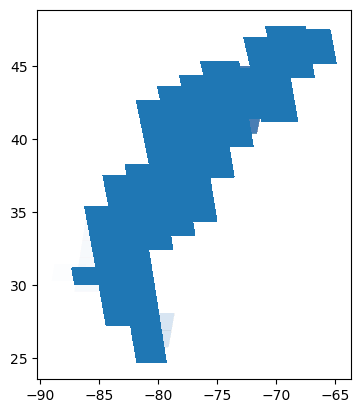

In [45]:
df_ifgs.plot(alpha=.01)

## Total IFGs

In [46]:
df_ifgs.shape

(71974, 9)

## Distribution of Temporal Baselines

In [47]:
xx = (df_ifgs.reference_date).map(pd.Timestamp) - (df_ifgs.secondary_date).map(pd.Timestamp)

In [48]:
yy = xx.dt.total_seconds() / (60 * 60 * 24)

Text(0.5, 0, 'Temporal Baseline (days)')

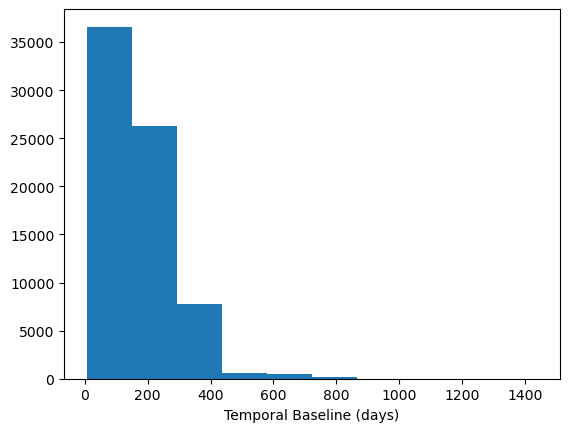

In [49]:
plt.hist(yy)
plt.xlabel('Temporal Baseline (days)')

In [57]:
nonempty_df = list(map(lambda df: int(not df.empty), dfs))
sum(nonempty_df)

16